#                                       Situação da COVID no Brasil


Estudo realizado no Bootcamp da Alura, onde teriamos que verificar os dados de COVID-19 no Brasil, explorando os resultados, tentando entender alguns fatores/fatos que podiamos entender através dos dados
As hispóteses podem ser muitas ao pensar sobre este problema. Será que o número de habitantes impacta nos números? O tamanho da cidade? Descaso com a doença? Número de voos? Clima? Escolaridade da região? Renda percapita?


Os passos para execução deste trabalho serão: Limpeza/Importação dos dados; Seleção de Municipios Alvos; Análise de Dados; e Conclusão.


Então prepare-se, pegue muito alcool em gel - de preferência 70% - e traga sua mascara. Let's code!

<img src='coronavirus.png' width=70%>

Fonte: site = https://www.santanafm.com.br/coronavirus-no-brasil-chega-a-400-o-numero-de-infectados/ // Cadu Rolim/Fotorarena/Estadão Conteúdo

## Análise dos dados:

Para iniciar nossa análise vamos limpar/ importar os dados que vamos utilizar. Trataremos de 2 bancos de dados

### 1º Passo: Importando as Bibliotecas / Importando & Limpando Bases de Dados

As bibliotecas que nos auxiliarão nessa análise são: pandas, matplotlib, numpy, copy e seaborn.

In [385]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import copy
import seaborn as sns

Queremos analisar todas as hipoteses que foram projetadas em nosso resumo, portanto precisaremos de MUITOS dados. As bases são:

• 	Casos da COVID até o dia 16/11/2020 (intitulada como "casos_full"). fonte - https://brasil.io/dataset/covid19/caso/

• 	Dados de óbitos do ano de 1970 até 08/2020 (intitulada como "obitos"). fonte - https://www.kaggle.com/amandalk/registered-deaths-brazil

• 	Área dos municipios brasileiro 2019 (intitulada como "area_mun"). fonte - https://www.ibge.gov.br/geociencias/organizacao-do-territorio/estrutura-territorial/15761-areas-dos-municipios.html?=&t=downloads

• 	Número de voos (intitulada como "num_voos"). fonte - https://www.anac.gov.br/assuntos/setor-regulado/empresas/envio-de-informacoes/microdados

• 	Quantidade de leitos que o SUS possui por municipio (intitulada como "leitos_sus"). fonte - http://tabnet.datasus.gov.br/cgi/deftohtm.exe?cnes/cnv/leiintbr.def

• 	Quantidade de leitos TOTAL por municipio (intitulada como "leitos_total"). fonte - http://tabnet.datasus.gov.br/cgi/deftohtm.exe?cnes/cnv/leiintbr.def

• 	Gastos por atendimento do SUS por municipio (intitulada como "gasto_sus"). fonte - http://tabnet.datasus.gov.br/

Abaixo teremos toda a extração das bases e a exclusão de dados incoerentes:

In [386]:
#Extração da base
casos_full = pd.read_csv('BASE/caso_full.csv.gz', compression='gzip')
#Exclusão de dados chamados de 'Importados/Indefinidos'. Estes são dados que não foram encontrados pela extração e, na análise 
# do dia 16/11/20, representam menos de 0% dos dados (9 linhas de 2884).
casos_full = casos_full[casos_full['city'] != 'Importados/Indefinidos']
cod_ibge = []
for i in casos_full['city_ibge_code']:
    a = str(i)
    cod_ibge.append(float(a[:6]))
casos_full['cod_ibge'] = cod_ibge

In [387]:
#Extração da base
obitos = pd.read_csv('BASE/deaths_brazil.csv', encoding = 'ISO-8859-1', sep =',', decimal =',')
#Excluindo os dados anteriores a 2018 - Vamos tirar o excesso de periodo da análise para minimizar o espaço de execução e 
#facilitar a manipulação da base de dados
obitos = obitos[obitos['year'] > 2017]
obitos_date = []
obitos_date.append(pd.to_datetime(obitos.year*10000+obitos.month*100+obitos.month,format='%Y%m%d'))
obitos['date'] = list(obitos_date[0])

In [388]:
#Extração da base
gasto_sus = pd.read_csv(r'C:\Users\bochn\ProjetosPython\Bootcamp_Alura_DataScience\1º Modulo\BASE\A215609189_28_143_208_atendimento.csv'
                   , encoding = 'ISO-8859-1', skiprows = 3, sep =';', decimal =',',na_values='-')
#Linhas para excluir de rodapé
n = 8
#Excluindo linhas de rodapé
gasto_sus.drop(gasto_sus.tail(n).index , 
        inplace = True) 

gasto_sus = gasto_sus[['Município','2018/Jan',
 '2018/Fev',
 '2018/Mar',
 '2018/Abr',
 '2018/Mai',
 '2018/Jun',
 '2018/Jul',
 '2018/Ago',
 '2018/Set',
 '2018/Out',
 '2018/Nov',
 '2018/Dez',
 '2019/Jan',
 '2019/Fev',
 '2019/Mar',
 '2019/Abr',
 '2019/Mai',
 '2019/Jun',
 '2019/Jul',
 '2019/Ago',
 '2019/Set',
 '2019/Out',
 '2019/Nov',
 '2019/Dez',
 '2020/Jan',
 '2020/Fev',
 '2020/Mar',
 '2020/Abr',
 '2020/Mai',
 '2020/Jun',
 '2020/Jul',
 '2020/Ago']]
cod_ibge = []
for i in gasto_sus['Município']:
    cod_ibge.append(float(i[:6]))
gasto_sus['cod_ibge'] = cod_ibge

In [389]:
#Extração da base
area_mun = pd.read_excel(r'C:\Users\bochn\ProjetosPython\Bootcamp_Alura_DataScience\1º Modulo\BASE\AR_BR_RG_UF_RGINT_RGIM_MES_MIC_MUN_2019.xls')
cod_ibge = []
for i in area_mun['CD_GCMUN']:
    i = str(i)
    cod_ibge.append(float(i[:6]))
area_mun['cod_ibge'] = cod_ibge


In [390]:
#Extração por mês de bases de voos com foco no destino e mês de chegada de janeiro a outubro
col_list = ["ds_natureza_etapa","nm_mes_chegada_real", "nr_passag_pagos", "nr_passag_gratis", "nm_municipio_destino", "sg_uf_destino", "nm_pais_destino"]
voos1 = pd.read_table(r'D:\Cursos\BOOTCAMP ALURA - DATASCIENCE 2020\Analisando dados de Saúde com Python e Pandas\bases\combinada2020-01.txt', encoding = 'ISO-8859-1', sep =';', usecols= col_list)
voos2 = pd.read_table(r'D:\Cursos\BOOTCAMP ALURA - DATASCIENCE 2020\Analisando dados de Saúde com Python e Pandas\bases\combinada2020-02.txt', encoding = 'ISO-8859-1', sep =';', usecols= col_list)
voos3 = pd.read_table(r'D:\Cursos\BOOTCAMP ALURA - DATASCIENCE 2020\Analisando dados de Saúde com Python e Pandas\bases\combinada2020-03.txt', encoding = 'ISO-8859-1', sep =';', usecols= col_list)
voos4 = pd.read_table(r'D:\Cursos\BOOTCAMP ALURA - DATASCIENCE 2020\Analisando dados de Saúde com Python e Pandas\bases\combinada2020-04.txt', encoding = 'ISO-8859-1', sep =';', usecols= col_list)
voos5 = pd.read_table(r'D:\Cursos\BOOTCAMP ALURA - DATASCIENCE 2020\Analisando dados de Saúde com Python e Pandas\bases\combinada2020-05.txt', encoding = 'ISO-8859-1', sep =';', usecols= col_list)
voos6 = pd.read_table(r'D:\Cursos\BOOTCAMP ALURA - DATASCIENCE 2020\Analisando dados de Saúde com Python e Pandas\bases\combinada2020-06.txt', encoding = 'ISO-8859-1', sep =';', usecols= col_list)
voos7 = pd.read_table(r'D:\Cursos\BOOTCAMP ALURA - DATASCIENCE 2020\Analisando dados de Saúde com Python e Pandas\bases\combinada2020-07.txt', encoding = 'ISO-8859-1', sep =';', usecols= col_list)
voos8 = pd.read_table(r'D:\Cursos\BOOTCAMP ALURA - DATASCIENCE 2020\Analisando dados de Saúde com Python e Pandas\bases\combinada2020-08.txt', encoding = 'ISO-8859-1', sep =';', usecols= col_list)
voos9 = pd.read_table(r'D:\Cursos\BOOTCAMP ALURA - DATASCIENCE 2020\Analisando dados de Saúde com Python e Pandas\bases\combinada2020-09.txt', encoding = 'ISO-8859-1', sep =';', usecols= col_list)
voos10 = pd.read_table(r'D:\Cursos\BOOTCAMP ALURA - DATASCIENCE 2020\Analisando dados de Saúde com Python e Pandas\bases\combinada2020-10.txt', encoding = 'ISO-8859-1', sep =';', usecols= col_list)

In [391]:
#Vamos concatenar todas as bases em um só DataFrame para facilitar a manipulação
voos = pd.concat([voos1,voos2,voos3,voos4,voos5,voos6,voos7,voos8,voos9,voos10])
#Excluimos todos os voos que não possuem destino no Brasil.
voos = voos[voos['nm_pais_destino'] == 'BRASIL']
#Criação de coluna com passageiros total
voos['passageiros_total'] = voos['nr_passag_gratis']+voos['nr_passag_pagos']

In [392]:
#criando a data formatada em voos
data_formatada = []
for i in voos['nm_mes_chegada_real']:
    if i =='JANEIRO':
        data_formatada.append('2020-01-01')
    elif i == 'FEVEREIRO':
        data_formatada.append('2020-02-01')
    elif i == 'MARÇO':
        data_formatada.append('2020-03-01')
    elif i == 'ABRIL':
        data_formatada.append('2020-04-01')
    elif i == 'MAIO':
        data_formatada.append('2020-05-01')
    elif i == 'JUNHO':
        data_formatada.append('2020-06-01')
    elif i == 'JULHO':
        data_formatada.append('2020-07-01')
    elif i == 'AGOSTO':
        data_formatada.append('2020-08-01')
    elif i == 'SETEMBRO':
        data_formatada.append('2020-09-01')
    elif i == 'OUTUBRO':
        data_formatada.append('2020-10-01')
    elif i == 'NOVEMBRO':
        data_formatada.append('2020-11-01')
    else:
        data_formatada.append('2020-12-01')
voos['data_formatada'] = data_formatada

In [393]:
#Extração da base
leitos_total = pd.read_csv(r'C:\Users\bochn\ProjetosPython\Bootcamp_Alura_DataScience\1º Modulo\BASE\A220855189_28_143_208_Total.csv'
                   , encoding = 'ISO-8859-1', skiprows = 3, sep =';', decimal =',',na_values='-')
#Linhas para excluir de rodapé
n = 10
#Excluindo linhas de rodapé
leitos_total.drop(leitos_total.tail(n).index , 
        inplace = True) 
cod_ibge = []
for i in leitos_total['Município']:
    cod_ibge.append(float(i[:6]))
leitos_total['cod_ibge'] = cod_ibge

In [394]:
#Extração da base
leitos_sus = pd.read_csv(r'C:\Users\bochn\ProjetosPython\Bootcamp_Alura_DataScience\1º Modulo\BASE\A220927189_28_143_208_Somente_Sus.csv'
                   , encoding = 'ISO-8859-1', skiprows = 3, sep =';', decimal =',',na_values='-')
#Linhas para excluir de rodapé
n = 10
#Excluindo linhas de rodapé
leitos_sus.drop(leitos_sus.tail(n).index , 
        inplace = True) 
cod_ibge = []
for i in leitos_sus['Município']:
    cod_ibge.append(float(i[:6]))
leitos_sus['cod_ibge'] = cod_ibge


### 2º Passo: Seleção de Municípios Alvos

Depois de limpar os dados, e deixar todos os DataFrames preparados para uso, agora vamos verificar os municipios alvos para nossa análise.
Como temos muita informação, vou focar nos 3 melhores/piores municipios nos seguintes indicadores:

• 	Quantidade de Pessoas Contaminadas (Dados COVID);

• 	% de habitantes contaminados - contaminados/total de habitantes projetados 2020 (Dados COVID);

• 	Quantidade de Óbitos (Dados COVID);

Outro detalhe importante é o nosso foco somente nas cidades acima do terceiro quartil. O intuito no foco do terceiro quartil ao quarto é para justamente analisarmos os lugares mais afetados pelo vírus.

#### Análise: Quantidade de Pessoas Contaminadas

In [395]:
#Selecionando apenas os dados da ultima semana
analise_qtd_contaminados = casos_full[(casos_full['epidemiological_week'] == 47 )& (casos_full['place_type'] == 'city')]
#Agrupando os dados para ter só um de cada cidade
analise_qtd_contaminados = pd.DataFrame(analise_qtd_contaminados.groupby('city_ibge_code')['last_available_confirmed'].max().sort_values(ascending = False))
#Descobrindo qual é o comportamento dos dados da Quantidade de Pessoas Contaminadas.
analise_qtd_contaminados['last_available_confirmed'].describe()

count      5569.000000
mean       1018.318010
std        6381.272929
min           0.000000
25%          69.000000
50%         195.000000
75%         589.000000
max      330753.000000
Name: last_available_confirmed, dtype: float64

In [396]:
#Extraindo somente os valores acima do Q3
valor = analise_qtd_contaminados['last_available_confirmed']
Q3 = valor.quantile(.75)
selecao = (valor >= Q3)
analise_qtd_contaminados_new = analise_qtd_contaminados[selecao]
top3_analise_qtd_contaminados = analise_qtd_contaminados_new.iloc[:3]
bot3_analise_qtd_contaminados = analise_qtd_contaminados_new.iloc[-3:]

In [397]:
escolha_analise_qtd_contaminados = pd.concat([pd.DataFrame(bot3_analise_qtd_contaminados.index),pd.DataFrame(top3_analise_qtd_contaminados.index)])
escolha_analise_qtd_contaminados
analise_qtd_contaminados = copy.copy(casos_full[casos_full['city_ibge_code'].isin(escolha_analise_qtd_contaminados['city_ibge_code'])])

In [398]:
ranking = []
for i in analise_qtd_contaminados['city_ibge_code']:
    if i in bot3_analise_qtd_contaminados.index:
        ranking.append('bottom')
    else:
        ranking.append('top')
        
analise_qtd_contaminados['ranking'] = ranking

In [399]:
analise_qtd_contaminados['city'].unique()

array(['São Paulo', 'Rio de Janeiro', 'Brasília', 'São Caitano',
       'Araioses', 'Três Coroas'], dtype=object)

Selecionamos para esse indicador as cidades de São Paulo, Rio de Janeiro, Brasilia, São Caitano, Araioses e Três Coroas.

#### Análise: % de Pessoas Contaminadas

In [400]:
#Selecionando apenas os dados da ultima semana
analise_perc_contaminados = casos_full[(casos_full['epidemiological_week'] == 47 )& (casos_full['place_type'] == 'city')]
#Agrupando os dados para ter só um de cada cidade
analise_perc_contaminados = pd.DataFrame(analise_perc_contaminados.groupby('city_ibge_code')['last_available_confirmed_per_100k_inhabitants'].max().sort_values(ascending = False))
#Descobrindo qual é o comportamento dos dados da taxa de contaminação do COVID.
analise_perc_contaminados['last_available_confirmed_per_100k_inhabitants'].describe()

count     5568.000000
mean      2194.724596
std       1787.115236
min         10.851870
25%        975.988628
50%       1765.187175
75%       2893.221070
max      22612.172370
Name: last_available_confirmed_per_100k_inhabitants, dtype: float64

In [401]:
#Extraindo somente os valores acima do Q3
valor = analise_perc_contaminados['last_available_confirmed_per_100k_inhabitants']
Q3 = valor.quantile(.75)
selecao = (valor >= Q3)
analise_perc_contaminados_new = analise_perc_contaminados[selecao]
top3_analise_perc_contaminados = analise_perc_contaminados_new.iloc[:3]
bot3_analise_perc_contaminados = analise_perc_contaminados_new.iloc[-3:]

In [402]:
escolha_analise_perc_contaminados = pd.concat([pd.DataFrame(bot3_analise_perc_contaminados.index),pd.DataFrame(top3_analise_perc_contaminados.index)])
analise_perc_contaminados
analise_perc_contaminados = copy.copy(casos_full[casos_full['city_ibge_code'].isin(escolha_analise_perc_contaminados['city_ibge_code'])])

In [403]:
ranking = []
for i in analise_perc_contaminados['city_ibge_code']:
    if i in bot3_analise_perc_contaminados.index:
        ranking.append('bottom')
    else:
        ranking.append('top')
        
analise_perc_contaminados['ranking'] = ranking

In [404]:
analise_perc_contaminados['city'].unique()

array(['Taboão da Serra', 'São Roque do Canaã', 'Vitória do Jari',
       'Caririaçu', 'Jacareacanga', 'Japurá'], dtype=object)

Selecionamos para esse indicador as cidades de Taboão da Serra, Vitória do Jari, São Roque do Canaã, Caririaçu, Jacareacanga e Japurá.

#### Análise: Quantidade de Óbitos

In [405]:
#Selecionando apenas os dados da ultima semana
analise_qtd_mortes = casos_full[(casos_full['epidemiological_week'] == 47 )& (casos_full['place_type'] == 'city')]
#Agrupando os dados para ter só um de cada cidade
analise_qtd_mortes = pd.DataFrame(analise_qtd_mortes.groupby('city_ibge_code')['last_available_deaths'].max().sort_values(ascending = False))
#Descobrindo qual é o comportamento dos dados da quantidade de óbitos gerados pelo COVID.
analise_qtd_mortes['last_available_deaths'].describe()

count     5569.000000
mean        29.078650
std        279.490396
min          0.000000
25%          1.000000
50%          4.000000
75%         12.000000
max      13958.000000
Name: last_available_deaths, dtype: float64

In [406]:
#Extraindo somente os valores acima do Q3
valor = analise_qtd_mortes['last_available_deaths']
Q3 = valor.quantile(.75)
selecao = (valor >= Q3)
analise_qtd_mortes_new = analise_qtd_mortes[selecao]
top3_analise_qtd_mortes = analise_qtd_mortes_new.iloc[:3]
bot3_analise_qtd_mortes = analise_qtd_mortes_new.iloc[-3:]

In [407]:
escolha_analise_qtd_mortes = pd.concat([pd.DataFrame(bot3_analise_qtd_mortes.index),pd.DataFrame(top3_analise_qtd_mortes.index)])
analise_qtd_mortes
analise_qtd_mortes = copy.copy(casos_full[casos_full['city_ibge_code'].isin(escolha_analise_qtd_mortes['city_ibge_code'])])

In [408]:
ranking = []
for i in analise_qtd_mortes['city_ibge_code']:
    if i in bot3_analise_qtd_mortes.index:
        ranking.append('bottom')
    else:
        ranking.append('top')
        
analise_qtd_mortes['ranking'] = ranking

In [409]:
analise_qtd_mortes['city'].unique()

array(['São Paulo', 'Rio de Janeiro', 'Fortaleza', 'Ortigueira',
       'Costa Rica', 'Terenos'], dtype=object)

Selecionamos para esse indicador as cidades de São Paulo, Rio de Janeiro, Fortaleza, Ortigueira, Costa Rica e Terenos.

### 3º Passo: Análise de Municípios Alvos

Este passo consistirá em analisar os municípios selecionados na 2ª etapa deste estudo, Comparando os números/resultados de dados atuais, com dados históricos para verificarmos a gravidade desse vírus tão nocivo para nossas vidas.

#### Timeline do Vírus no Brasil

09/02/2020 - 34 brasileiros repatriados em Anápolis (GO) que viviam na cidade chinesa de Wuhan.

20/02/2020 - 1º caso suspeito em São Paulo / SP.

26/02/2020 - Confirmado 1º caso de coronavírus no Brasil - Em São Paulo / SP.

11/03/2020 - Organização Mundial de Saúde declarou pandemia de Coronavírus.

12/03/2020 - Abertura de 5.811 vagas para médicos trabalharem nos postos de sáude.

16/03/2020 - 234 casos confirmados. Rio de Janeiro e São Paulo registram transmissão comunitária, quando não há identificação da origem da contaminação. Ministério da Saúde libera R$432Mi para estados reforçarem o plano de contingência. Mais de 500 leitos serão distribuidos pelo Brasil.

17/03/2020 - 1ª morte por coronavírus no Brasil - São Paulo / SP. Estado do Rio de Janeiro decreta situação de emergência e inicia lockdown

22/03/2020 - Jair Bolsonaro edita medida provisória que autoriza a suspensão do contrato de trabalho por até quatro meses.

22/03/2020 - Começa no Brasil a restrição de entrada de estrangeiros.

25/03/2020 - Ministério da Saúde anuncia repasse de R$ 600 milhões para estados e municípios reforçarem o plano de contingência para enfrentamento do novo coronavírus.

25/03/2020 - Criação de Canal de atendimento para tirar dúvidas via whatsapp.

27/03/2020 - Investimento de R$ 4 milhões do Ministério da Saúde. Um dos lugares onde será executada é o Centro Hospitalar para a Pandemia da Covid-19, no Rio de Janeiro.

30/03/2020 - Residentes ganham bonificação de 20% sobre o valor da bolsa, equivalente a R$ 667,00, por trabalharem no enfrentamento à epidemia do novo coronavírus.

02/04/2020 - Todos devem utilizar máscara.

15/04/2020 - Quase 3,4 mil médicos são autorizados a iniciar atividades em 1,2 mil municípios de todos os estados, do Distrito Federal e dos Distritos Sanitários Especiais Indígenas.

16/04/2020 - Presidente da República, Jair Bolsonaro, decide exonerar o ministro da Saúde, Luiz Henrique Mandetta. Quem assume o ministério é o médico oncologista e empresário Nelson Teich.

07/05/2020 - Seis estados apresentam colapso na rede privada de saúde. Rio de Janeiro, Ceará, Pernambuco, Amazonas, Maranhão e Pará não têm mais leitos de UTI que podem ser contratados pela rede pública.

08/05/2020 - São Paulo prorroga quarentena até 31 de maio. Rio de Janeiro considera possibilidade de decretar lockdown em todo o estado, com bloqueio de estradas e restrição de circulação.

11/05/2020 - Vários municípios entrando em lockdown.

14/05/2020 - Instituído o Gabinete de Crise para enfrentamento da Covid-19 no Sistema Único de Saúde (SUS).

15/05/2020 - Ministro da Saúde, Nelson Teich, pede demissão do cargo pouco menos de um mês à frente da pasta.

16/05/2020 - São Paulo supera a China em número de mortes por causa da doença.

18/05/2020 - Farmacêutica americana anuncia que primeira vacina contra o novo coronavírus teve resposta positiva em humanos.

20/05/2020 - Ministério da Saúde, sob comando do ministro interino Eduardo Pazuello, divulga protocolo para uso da cloroquina e da hidroxicloroquina em casos leves da doença.

27/05/2020 - São Paulo anuncia plano de reabertura da economia. Retomada gradual acontecerá em regiões que tiverem redução no número de casos, disponibilidade de leitos hospitalares e obediência ao distanciamento social.

28/05/2020 - Capitais como São Paulo, Rio de Janeiro, Fortaleza e Manaus planejam reabertura da atividade econômica a partir de 1º de junho. No entanto, os quatro estados são os mais críticos.

02/06/2020 - Em semana na qual cidades iniciam flexibilização das restrições, Organização Pan-Americana de Saúde (Opas) recomenda cautela. Entidade avalia que segunda onda de contaminação do novo coronavírus pode colocar em risco os esforços feitos.

04/06/2020 - Ministério da Saúde muda forma de divulgação dos dados diários da pandemia de coronavírus no Brasil. A partir de então passa de 19h para 22h a publicização do balanço. Durante os próximos 4 dias a plataforma sofrerá várias desestabilizações com ordens do Presidente com a justificativa que estava sendo aplicada correções no sistema.

11/06/2020 - Presidente Jair Bolsonaro pede que seus seguidores tentem entrar em hospitais públicos e de campanha para verificar se leitos de emergência estão livres ou ocupados. Objetivo é que eles gravem o que encontrarem e mandem para o governo.

fonte: https://www.sanarmed.com/linha-do-tempo-do-coronavirus-no-brasil

#### Análise dos Dados dos Municípios Alvos

#### Inidicador de QTD de pessoas contaminadas - TOP3

In [410]:
#Analisando apenas os municípios alvos no KPI de QTD de Contaminados
analise_qtd_contaminados['last_available_date'] = pd.to_datetime(analise_qtd_contaminados['last_available_date'], format = '%Y-%m-%d')
analise_cont = analise_qtd_contaminados[['city','last_available_date','last_available_confirmed','ranking']]

(0.0, 380753.0)

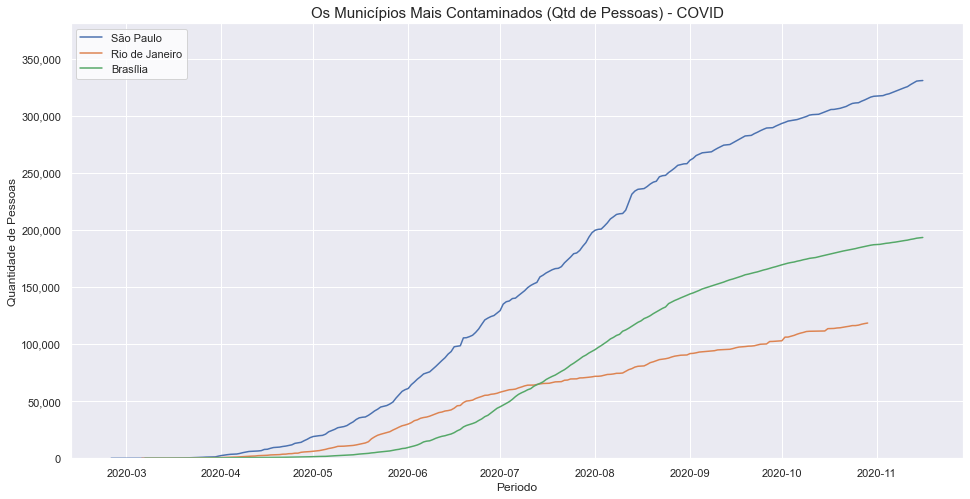

In [411]:
#Analisar os 3 primeiros
selec_1 = analise_cont[analise_cont['ranking'] == 'top']
sns.set_theme(style="darkgrid")
plt.figure(figsize=(16,8))
ax = sns.lineplot(x="last_available_date", y="last_available_confirmed",
             hue="city",
             data=selec_1)
plt.title('Os Municípios Mais Contaminados (Qtd de Pessoas) - COVID', fontsize=15)
plt.xlabel('Periodo', fontsize=12)
plt.ylabel('Quantidade de Pessoas', fontsize=12)
legend = plt.legend(loc=2)
frame = legend.get_frame()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
frame.set_facecolor('white')
maxlim = selec_1["last_available_confirmed"].max()
plt.ylim(0, maxlim+50000)

(0.0, 362164.0)

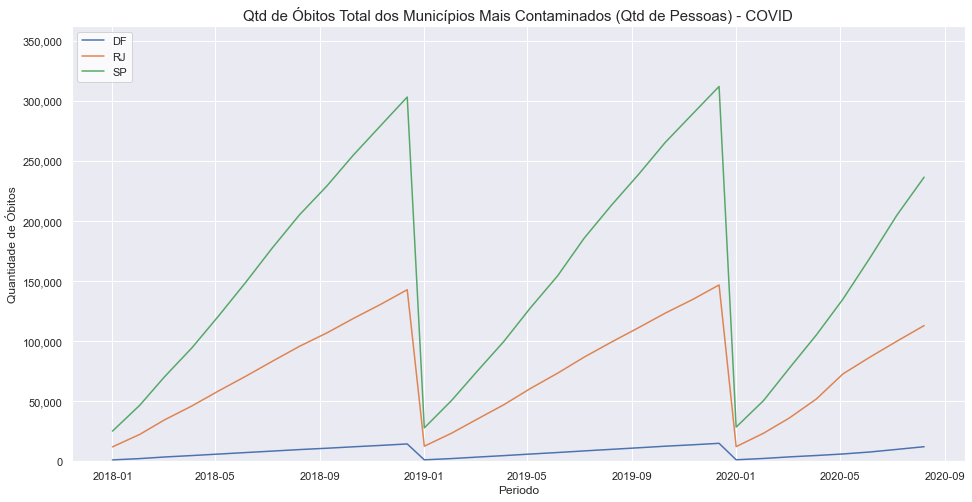

In [412]:
#Verificar o comportamento do gráfico sobre a qtd de óbitos nos estados dos municípios
selec_1 = obitos[obitos['state'].isin(analise_qtd_contaminados[analise_cont['ranking'] == 'top']['state'].unique())]
selec_1 = selec_1.sort_values(['year','state','month'])
selec_1['mortes_acum']=selec_1.groupby(['year','state'])['deaths'].cumsum()
plt.figure(figsize=(16,8))
ax = sns.lineplot(x="date", y="mortes_acum",
             hue="state",
             data=selec_1)
plt.title('Qtd de Óbitos Total dos Municípios Mais Contaminados (Qtd de Pessoas) - COVID', fontsize=15)
plt.xlabel('Periodo', fontsize=12)
plt.ylabel('Quantidade de Óbitos', fontsize=12)
legend = plt.legend(loc=2)
frame = legend.get_frame()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
frame.set_facecolor('white')
maxlim = selec_1["mortes_acum"].max()
plt.ylim(0, maxlim+50000)

Text(0, 0.5, 'Quantidade de Óbitos')

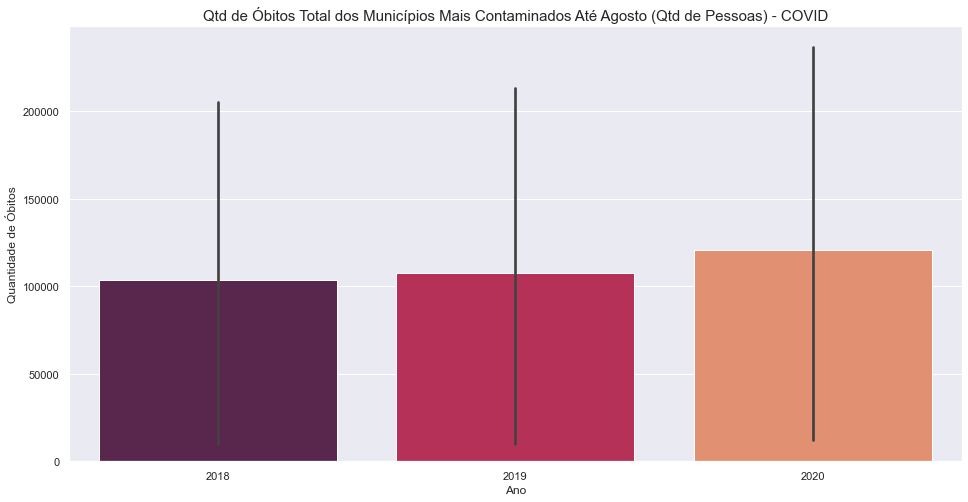

In [413]:
#Avaliar a QTD de óbitos acumuladas até Agosto
selec_1 = selec_1[selec_1['month'] == 8]

plt.figure(figsize=(16,8))
sns.barplot(x='year', y="mortes_acum", palette="rocket", data=selec_1)
plt.title('Qtd de Óbitos Total dos Municípios Mais Contaminados Até Agosto (Qtd de Pessoas) - COVID', fontsize=15)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Quantidade de Óbitos', fontsize=12)

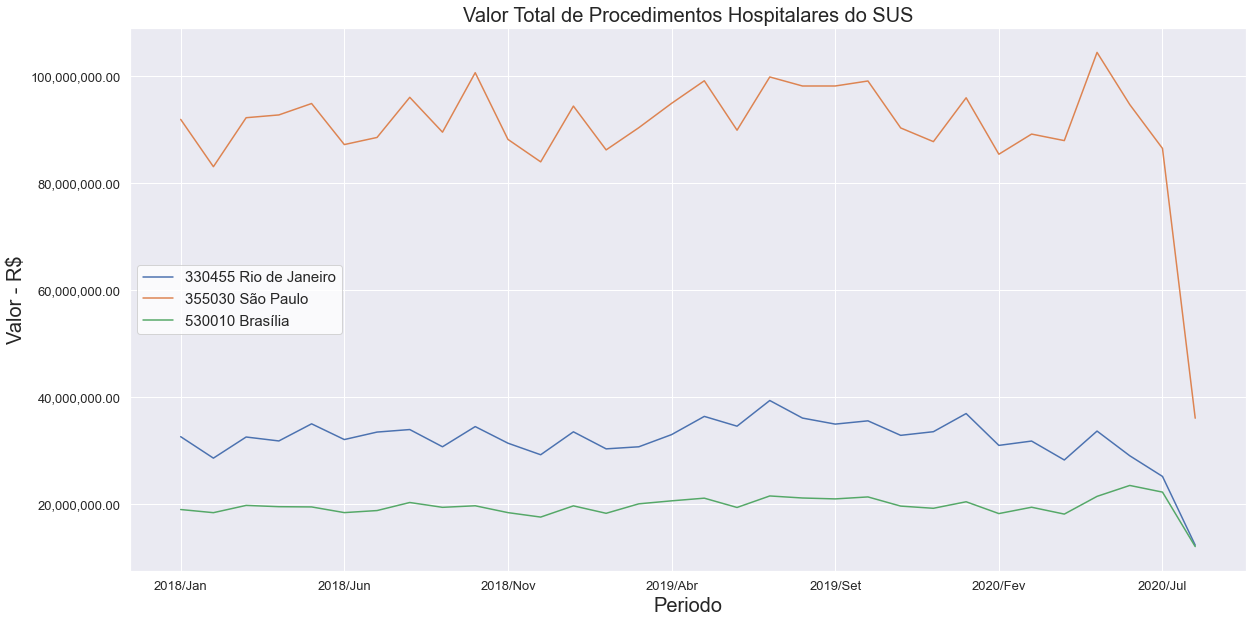

In [414]:
#Avaliar os gastos do SUS
selec = gasto_sus[gasto_sus['cod_ibge'].isin(analise_qtd_contaminados[analise_cont['ranking'] == 'top']['cod_ibge'])]
selec = selec.set_index('Município')
x =selec.T[:-1].plot(figsize = (20,10))
plt.title('Valor Total de Procedimentos Hospitalares do SUS', fontsize=20)
plt.xlabel('Periodo', fontsize=20)
plt.ylabel('Valor - R$', fontsize=20)
x.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
#plt.ylim(0, max(maximos)+15000000)
legend = plt.legend(loc='best',prop={'size': 15})
frame = legend.get_frame()
frame.set_facecolor('white')
x.tick_params(labelsize=13)

In [415]:
lista_de_aeroportos = ['GUARULHOS', 'SÃO PAULO', 'RIO DE JANEIRO', 'BRASÍLIA']
selec = pd.DataFrame(voos[voos['nm_municipio_destino'].isin(lista_de_aeroportos)].groupby(['data_formatada','nm_municipio_destino'])['passageiros_total'].sum())

(0.0, 2208079.0)

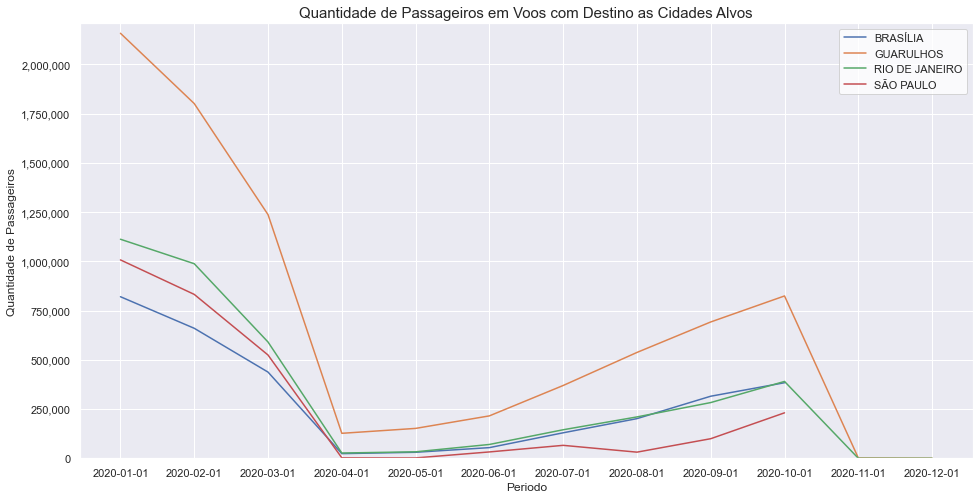

In [416]:
plt.figure(figsize=(16,8))
ax = sns.lineplot(x="data_formatada", y="passageiros_total",
             hue="nm_municipio_destino",
             data=selec)
plt.title('Quantidade de Passageiros em Voos com Destino as Cidades Alvos', fontsize=15)
plt.xlabel('Periodo', fontsize=12)
plt.ylabel('Quantidade de Passageiros', fontsize=12)
legend = plt.legend(loc='best')
frame = legend.get_frame()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
frame.set_facecolor('white')
maxlim = selec["passageiros_total"].max()
plt.ylim(0, maxlim+50000)

Text(0, 0.5, 'Km^2')

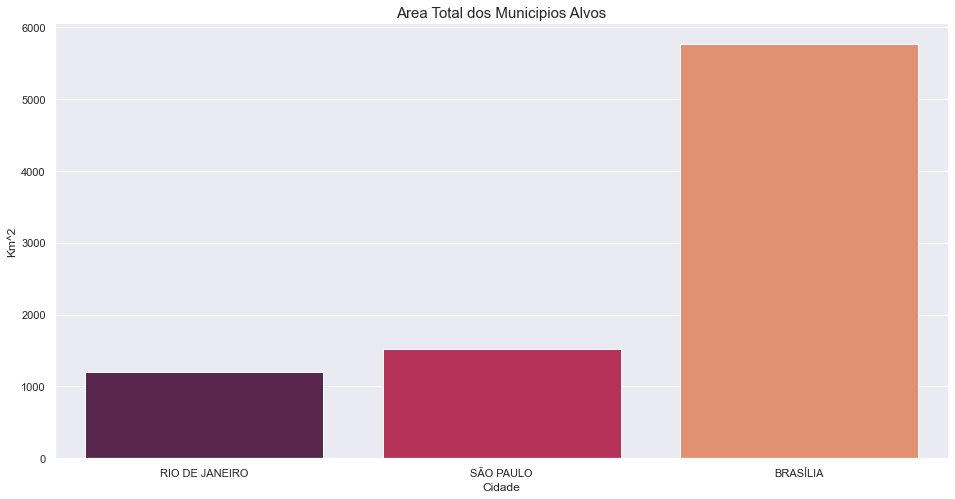

In [417]:
selec = area_mun[area_mun['cod_ibge'].isin(analise_qtd_contaminados[analise_cont['ranking'] == 'top']['cod_ibge'])]
plt.figure(figsize=(16,8))
sns.barplot(x='NM_MUN_2019', y="AR_MUN_2019", palette="rocket", data=selec)
plt.title('Area Total dos Municipios Alvos', fontsize=15)
plt.xlabel('Cidade', fontsize=12)
plt.ylabel('Km^2', fontsize=12)

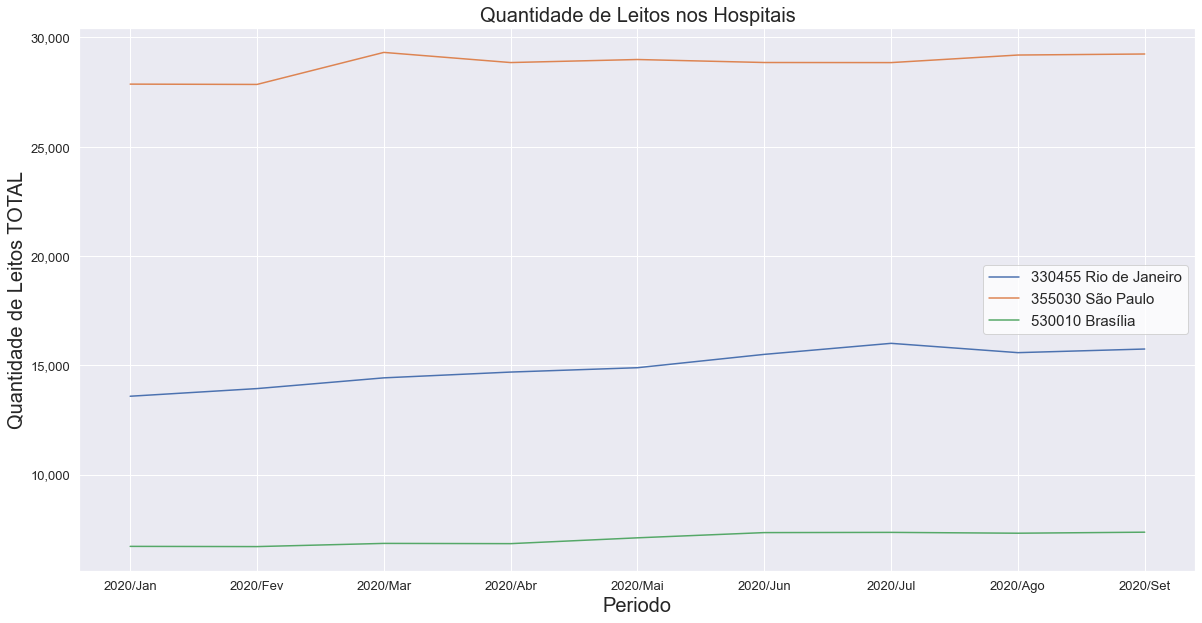

In [418]:
selec = leitos_total[leitos_total['cod_ibge'].isin(analise_qtd_contaminados[analise_cont['ranking'] == 'top']['cod_ibge'])]
selec = selec.set_index('Município')
x =selec.T[:-1].plot(figsize = (20,10))
plt.title('Quantidade de Leitos nos Hospitais', fontsize=20)
plt.xlabel('Periodo', fontsize=20)
plt.ylabel('Quantidade de Leitos TOTAL', fontsize=20)
x.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
#plt.ylim(0, max(maximos)+15000000)
legend = plt.legend(loc='best',prop={'size': 15})
frame = legend.get_frame()
frame.set_facecolor('white')
x.tick_params(labelsize=13)

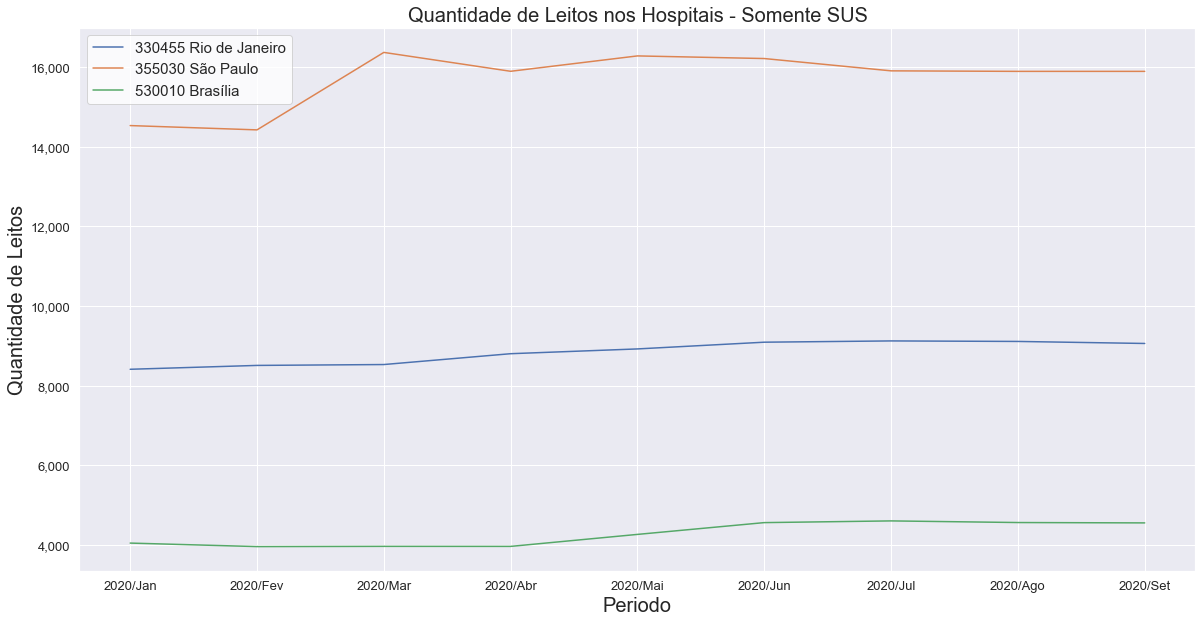

In [419]:
selec = leitos_sus[leitos_sus['cod_ibge'].isin(analise_qtd_contaminados[analise_cont['ranking'] == 'top']['cod_ibge'])]
selec = selec.set_index('Município')
x =selec.T[:-1].plot(figsize = (20,10))
plt.title('Quantidade de Leitos nos Hospitais - Somente SUS', fontsize=20)
plt.xlabel('Periodo', fontsize=20)
plt.ylabel('Quantidade de Leitos', fontsize=20)
x.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
#plt.ylim(0, max(maximos)+15000000)
legend = plt.legend(loc='best',prop={'size': 15})
frame = legend.get_frame()
frame.set_facecolor('white')
x.tick_params(labelsize=13)

#### Inidicador de QTD de pessoas contaminadas - BOTTOM3

In [420]:
#Analisando apenas os municípios alvos no KPI de QTD de Contaminados
analise_qtd_contaminados['last_available_date'] = pd.to_datetime(analise_qtd_contaminados['last_available_date'], format = '%Y-%m-%d')
analise_cont = analise_qtd_contaminados[['city','last_available_date','last_available_confirmed','ranking']]


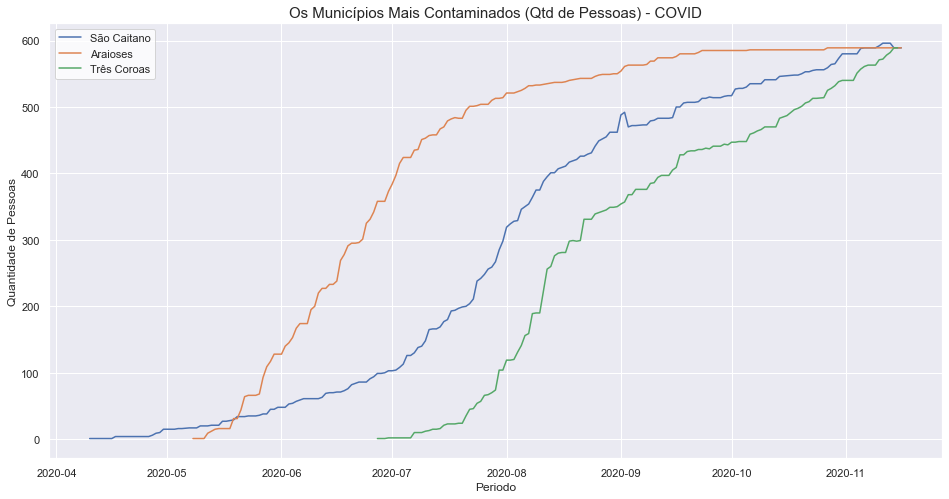

In [421]:
#Analisar os 3 ultimos
selec_1 = analise_cont[analise_cont['ranking'] == 'bottom']
sns.set_theme(style="darkgrid")
plt.figure(figsize=(16,8))
ax = sns.lineplot(x="last_available_date", y="last_available_confirmed",
             hue="city",
             data=selec_1)
plt.title('Os Municípios Mais Contaminados (Qtd de Pessoas) - COVID', fontsize=15)
plt.xlabel('Periodo', fontsize=12)
plt.ylabel('Quantidade de Pessoas', fontsize=12)
legend = plt.legend(loc=2)
frame = legend.get_frame()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
frame.set_facecolor('white')
maxlim = selec_1["last_available_confirmed"].max()


(0.0, 139990.0)

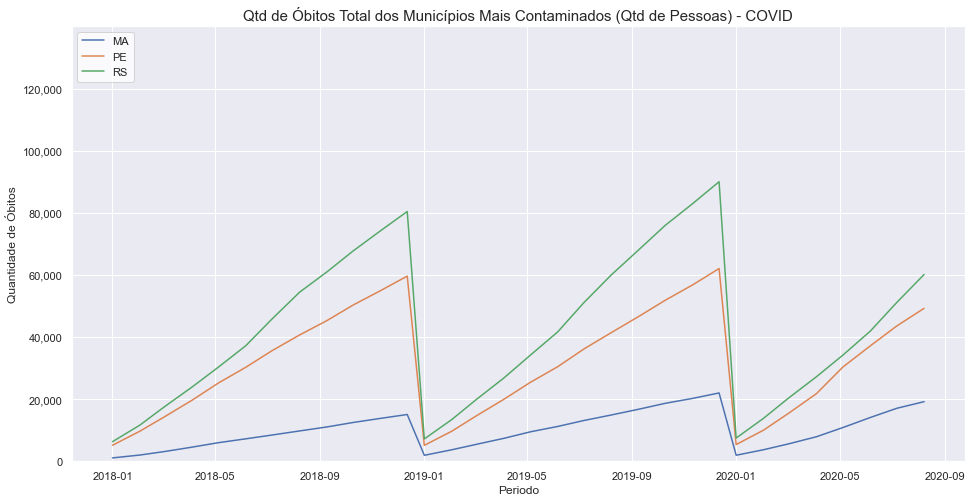

In [422]:
#Verificar o comportamento do gráfico sobre a qtd de óbitos nos estados dos municípios
selec_1 = obitos[obitos['state'].isin(analise_qtd_contaminados[analise_cont['ranking'] == 'bottom']['state'].unique())]
selec_1 = selec_1.sort_values(['year','state','month'])
selec_1['mortes_acum']=selec_1.groupby(['year','state'])['deaths'].cumsum()
plt.figure(figsize=(16,8))
ax = sns.lineplot(x="date", y="mortes_acum",
             hue="state",
             data=selec_1)
plt.title('Qtd de Óbitos Total dos Municípios Mais Contaminados (Qtd de Pessoas) - COVID', fontsize=15)
plt.xlabel('Periodo', fontsize=12)
plt.ylabel('Quantidade de Óbitos', fontsize=12)
legend = plt.legend(loc=2)
frame = legend.get_frame()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
frame.set_facecolor('white')
maxlim = selec_1["mortes_acum"].max()
plt.ylim(0, maxlim+50000)

Text(0, 0.5, 'Quantidade de Óbitos')

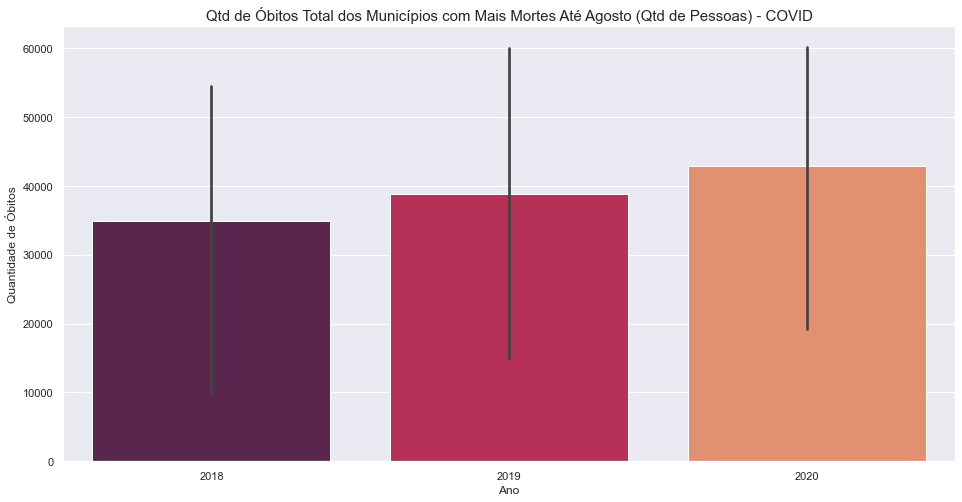

In [423]:
#Avaliar a QTD de óbitos acumuladas até Agosto
selec_1 = selec_1[selec_1['month'] == 8]
plt.figure(figsize=(16,8))
sns.barplot(x='year', y="mortes_acum", palette="rocket", data=selec_1)
plt.title('Qtd de Óbitos Total dos Municípios com Mais Mortes Até Agosto (Qtd de Pessoas) - COVID', fontsize=15)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Quantidade de Óbitos', fontsize=12)

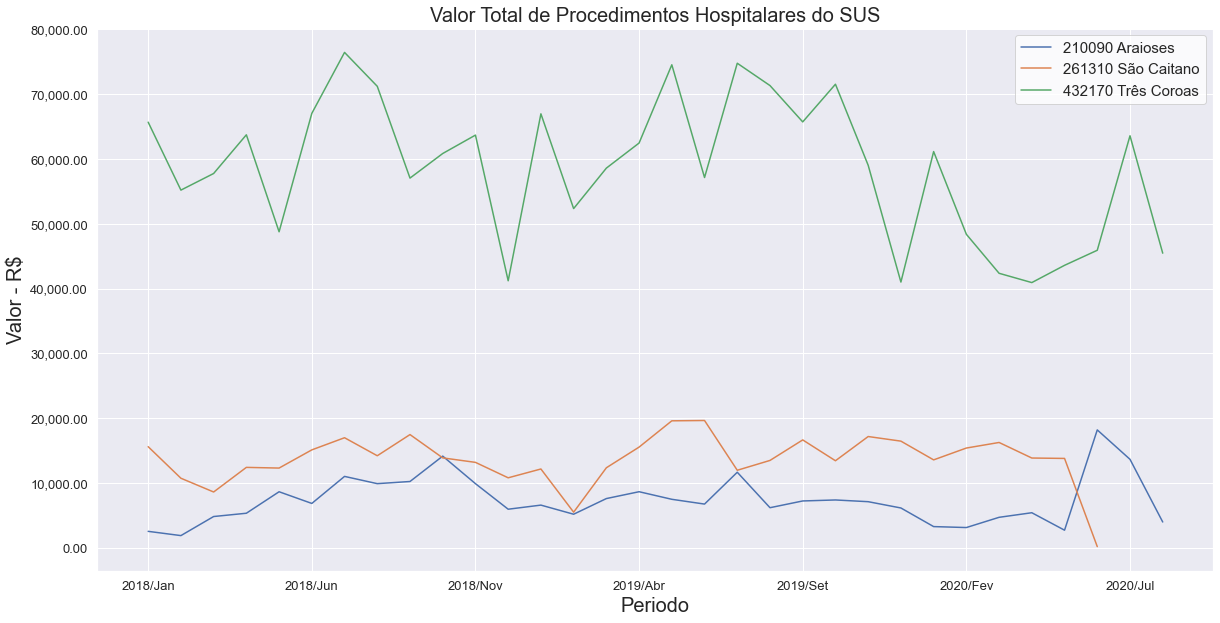

In [424]:
#Avaliar os gastos do SUS
selec = gasto_sus[gasto_sus['cod_ibge'].isin(analise_qtd_contaminados[analise_cont['ranking'] == 'bottom']['cod_ibge'])]
selec = selec.set_index('Município')
x =selec.T[:-1].plot(figsize = (20,10))
plt.title('Valor Total de Procedimentos Hospitalares do SUS', fontsize=20)
plt.xlabel('Periodo', fontsize=20)
plt.ylabel('Valor - R$', fontsize=20)
x.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
#plt.ylim(0, max(maximos)+15000000)
legend = plt.legend(loc='best',prop={'size': 15})
frame = legend.get_frame()
frame.set_facecolor('white')
x.tick_params(labelsize=13)

As três cidades não possuem aeroporto.

Text(0, 0.5, 'Km^2')

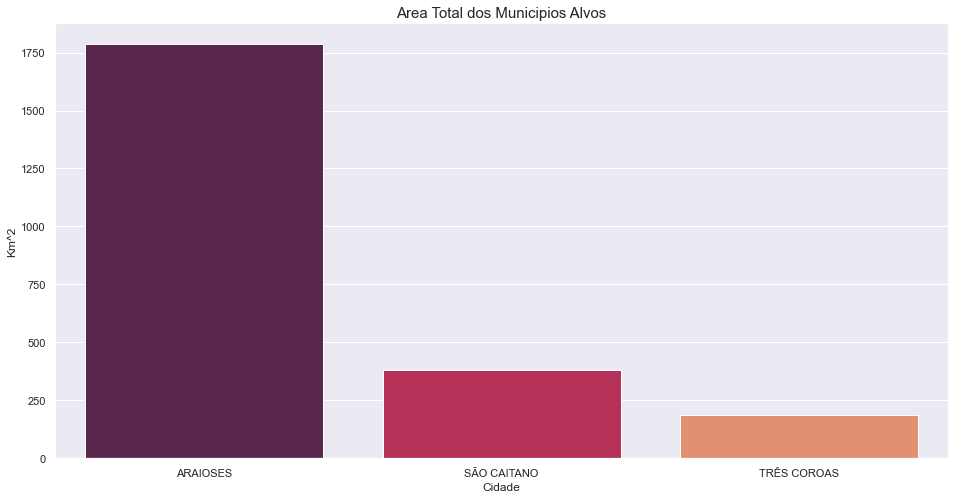

In [425]:
selec = area_mun[area_mun['cod_ibge'].isin(analise_qtd_contaminados[analise_cont['ranking'] == 'bottom']['cod_ibge'])]
plt.figure(figsize=(16,8))
sns.barplot(x='NM_MUN_2019', y="AR_MUN_2019", palette="rocket", data=selec)
plt.title('Area Total dos Municipios Alvos', fontsize=15)
plt.xlabel('Cidade', fontsize=12)
plt.ylabel('Km^2', fontsize=12)

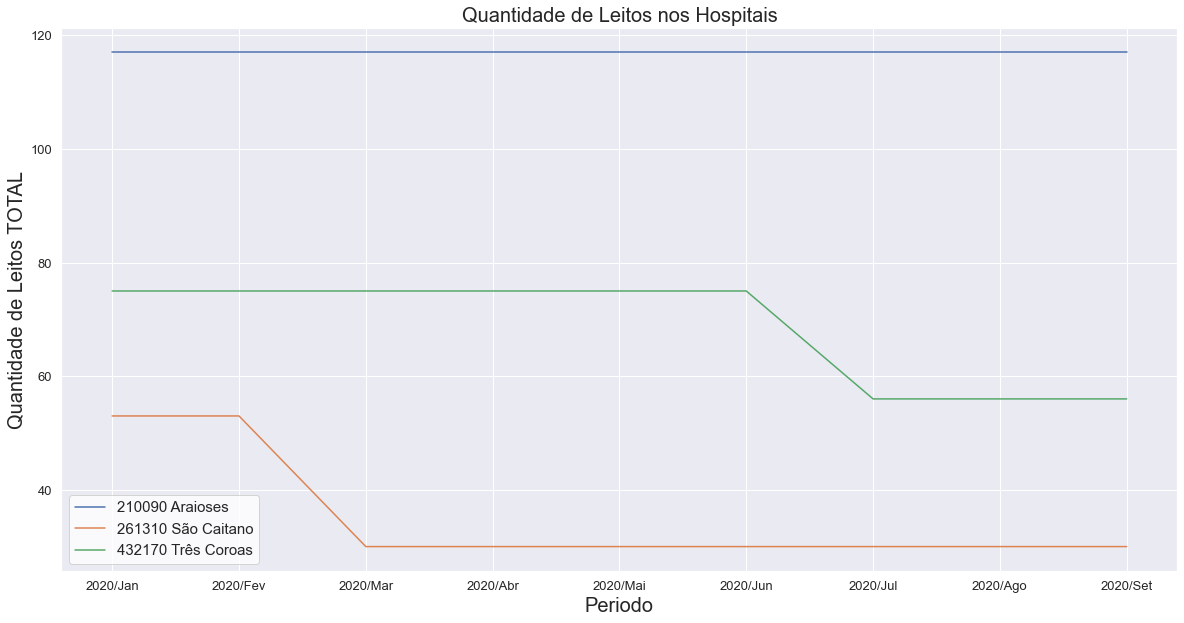

In [426]:
selec = leitos_total[leitos_total['cod_ibge'].isin(analise_qtd_contaminados[analise_cont['ranking'] == 'bottom']['cod_ibge'])]
selec = selec.set_index('Município')
x =selec.T[:-1].plot(figsize = (20,10))
plt.title('Quantidade de Leitos nos Hospitais', fontsize=20)
plt.xlabel('Periodo', fontsize=20)
plt.ylabel('Quantidade de Leitos TOTAL', fontsize=20)
x.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
#plt.ylim(0, max(maximos)+15000000)
legend = plt.legend(loc='best',prop={'size': 15})
frame = legend.get_frame()
frame.set_facecolor('white')
x.tick_params(labelsize=13)

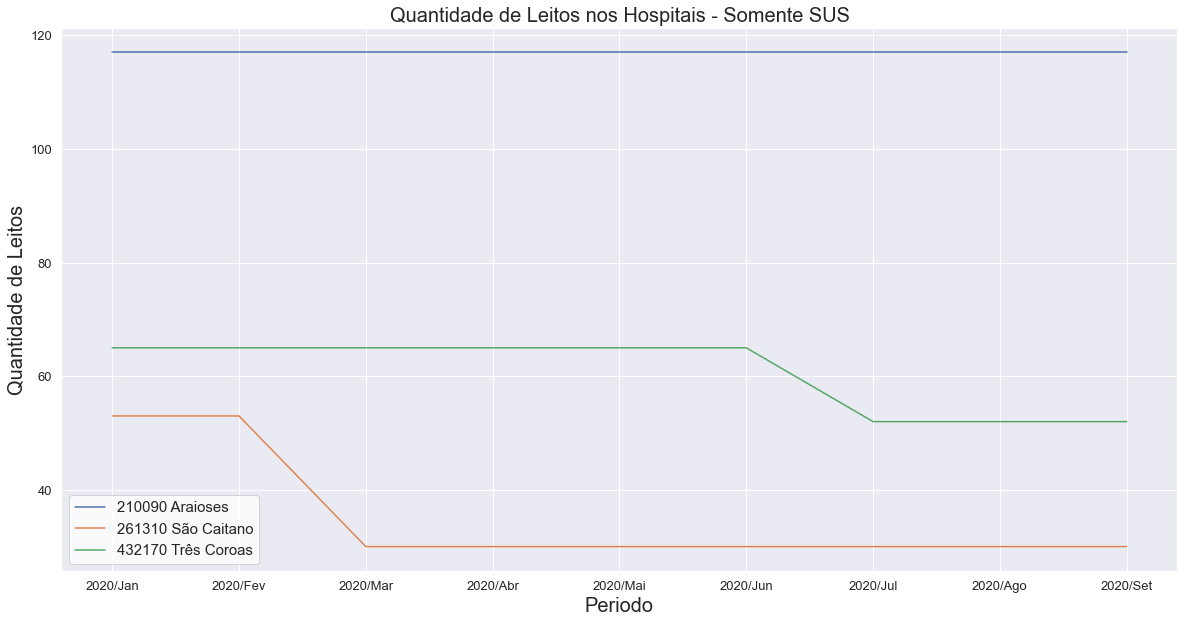

In [427]:
selec = leitos_sus[leitos_sus['cod_ibge'].isin(analise_qtd_contaminados[analise_cont['ranking'] == 'bottom']['cod_ibge'])]
selec = selec.set_index('Município')
x =selec.T[:-1].plot(figsize = (20,10))
plt.title('Quantidade de Leitos nos Hospitais - Somente SUS', fontsize=20)
plt.xlabel('Periodo', fontsize=20)
plt.ylabel('Quantidade de Leitos', fontsize=20)
x.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
#plt.ylim(0, max(maximos)+15000000)
legend = plt.legend(loc='best',prop={'size': 15})
frame = legend.get_frame()
frame.set_facecolor('white')
x.tick_params(labelsize=13)

#### Inidicador de % de pessoas contaminadas - TOP3

In [428]:
#Analisando apenas os municípios alvos no KPI de % de Contaminados
analise_perc_contaminados['last_available_date'] = pd.to_datetime(analise_perc_contaminados['last_available_date'], format = '%Y-%m-%d')
analise_cont = analise_perc_contaminados[['city','last_available_date','last_available_confirmed_per_100k_inhabitants','ranking']]

(0.0, 22712.17237)

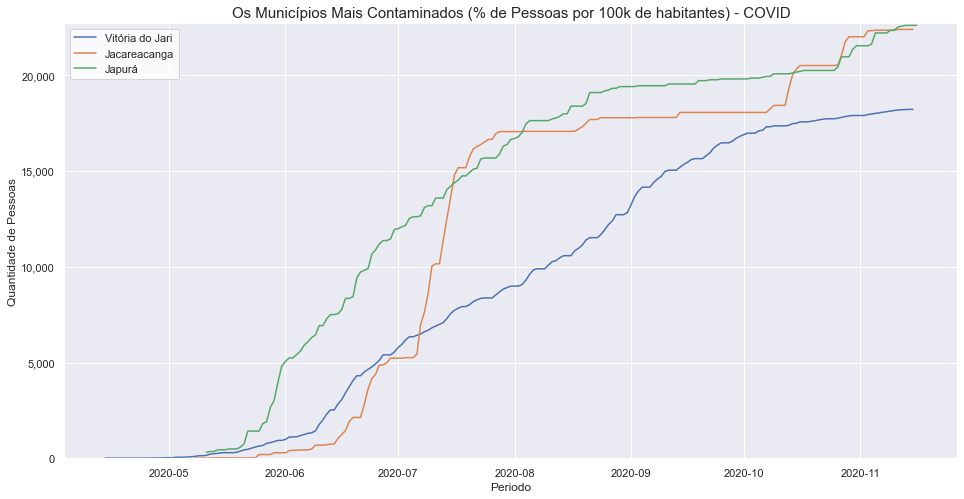

In [429]:
#Analisar os 3 primeiros
selec_1 = analise_cont[analise_cont['ranking'] == 'top']
sns.set_theme(style="darkgrid")
plt.figure(figsize=(16,8))
ax = sns.lineplot(x="last_available_date", y="last_available_confirmed_per_100k_inhabitants",
             hue="city",
             data=selec_1)
plt.title('Os Municípios Mais Contaminados (% de Pessoas por 100k de habitantes) - COVID', fontsize=15)
plt.xlabel('Periodo', fontsize=12)
plt.ylabel('Quantidade de Pessoas', fontsize=12)
legend = plt.legend(loc=2)
frame = legend.get_frame()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
frame.set_facecolor('white')
maxlim = selec_1["last_available_confirmed_per_100k_inhabitants"].max()
plt.ylim(0, maxlim+100)

(0.0, 26699.0)

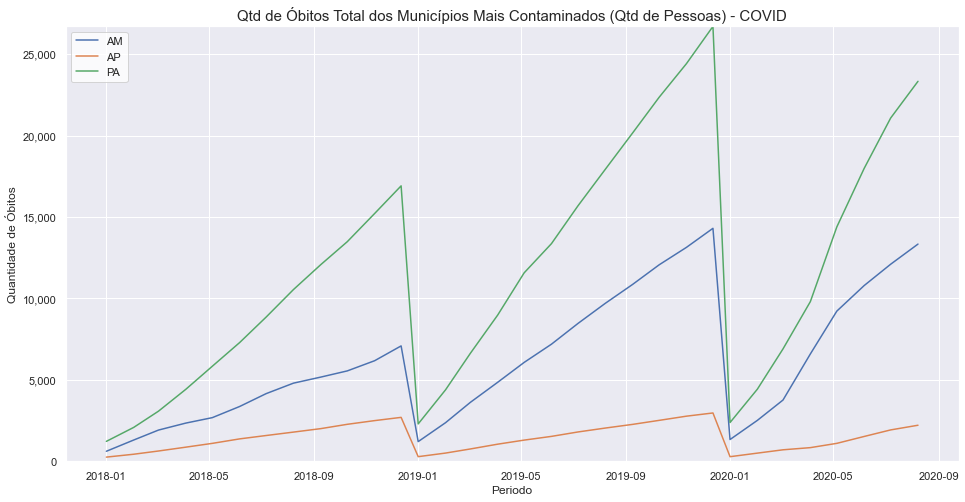

In [430]:
#Verificar o comportamento do gráfico sobre a qtd de óbitos nos estados dos municípios
selec_1 = obitos[obitos['state'].isin(analise_perc_contaminados[analise_cont['ranking'] == 'top']['state'].unique())]
selec_1 = selec_1.sort_values(['year','state','month'])
selec_1['mortes_acum']=selec_1.groupby(['year','state'])['deaths'].cumsum()
plt.figure(figsize=(16,8))
ax = sns.lineplot(x="date", y="mortes_acum",
             hue="state",
             data=selec_1)
plt.title('Qtd de Óbitos Total dos Municípios Mais Contaminados (Qtd de Pessoas) - COVID', fontsize=15)
plt.xlabel('Periodo', fontsize=12)
plt.ylabel('Quantidade de Óbitos', fontsize=12)
legend = plt.legend(loc=2)
frame = legend.get_frame()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
frame.set_facecolor('white')
maxlim = selec_1["mortes_acum"].max()
plt.ylim(0, maxlim)

Text(0, 0.5, 'Quantidade de Óbitos')

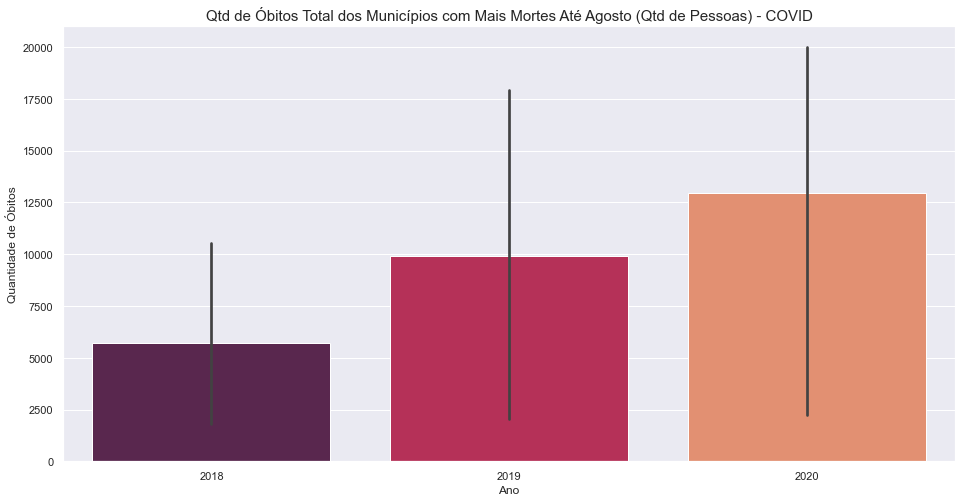

In [431]:
#Avaliar a QTD de óbitos acumuladas até Agosto
selec_1 = selec_1[selec_1['month'] == 8]
plt.figure(figsize=(16,8))
sns.barplot(x='year', y="mortes_acum", palette="rocket", data=selec_1)
plt.title('Qtd de Óbitos Total dos Municípios com Mais Mortes Até Agosto (Qtd de Pessoas) - COVID', fontsize=15)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Quantidade de Óbitos', fontsize=12)

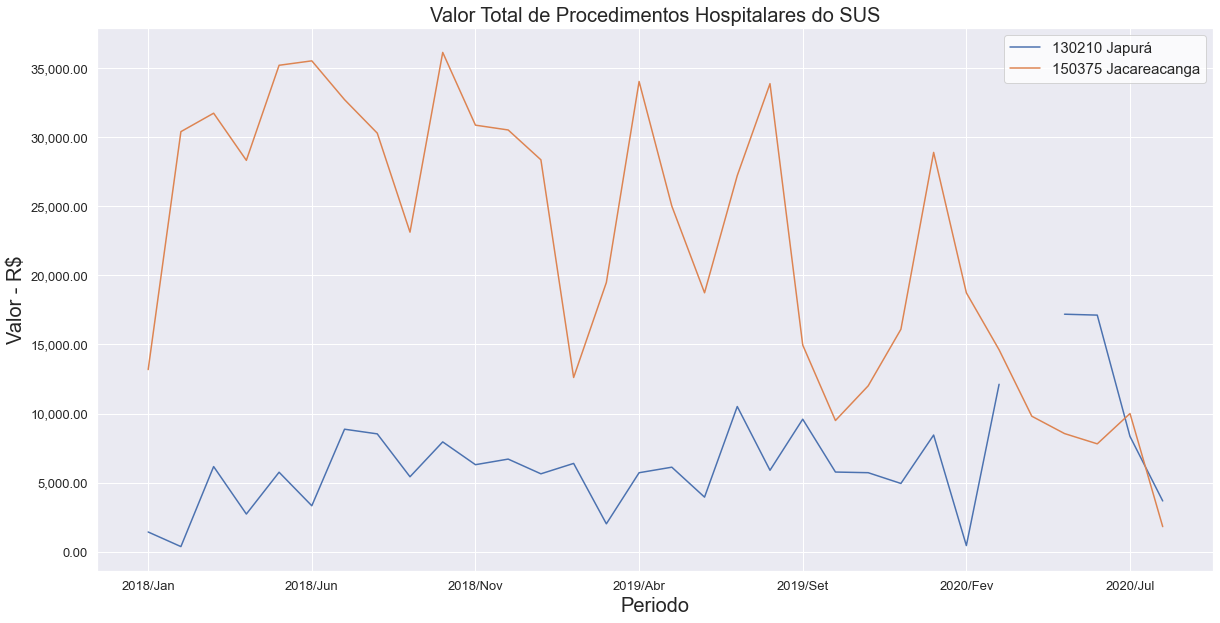

In [432]:
#Avaliar os gastos do SUS
selec = gasto_sus[gasto_sus['cod_ibge'].isin(analise_perc_contaminados[analise_cont['ranking'] == 'top']['cod_ibge'])]
selec = selec.set_index('Município')
x =selec.T[:-1].plot(figsize = (20,10))
plt.title('Valor Total de Procedimentos Hospitalares do SUS', fontsize=20)
plt.xlabel('Periodo', fontsize=20)
plt.ylabel('Valor - R$', fontsize=20)
x.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
#plt.ylim(0, max(maximos)+15000000)
legend = plt.legend(loc='best',prop={'size': 15})
frame = legend.get_frame()
frame.set_facecolor('white')
x.tick_params(labelsize=13)

Apesar de Jacareacanga e Japurá terem aeroportos, não foi encontrado dados das duas cidades na bases

Text(0, 0.5, 'Km^2')

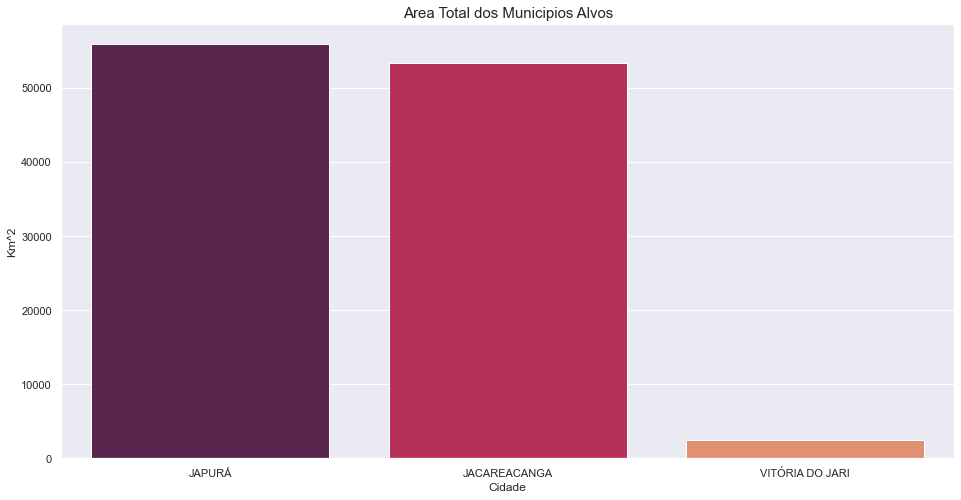

In [433]:
selec = area_mun[area_mun['cod_ibge'].isin(analise_perc_contaminados[analise_cont['ranking'] == 'top']['cod_ibge'])]
plt.figure(figsize=(16,8))
sns.barplot(x='NM_MUN_2019', y="AR_MUN_2019", palette="rocket", data=selec)
plt.title('Area Total dos Municipios Alvos', fontsize=15)
plt.xlabel('Cidade', fontsize=12)
plt.ylabel('Km^2', fontsize=12)

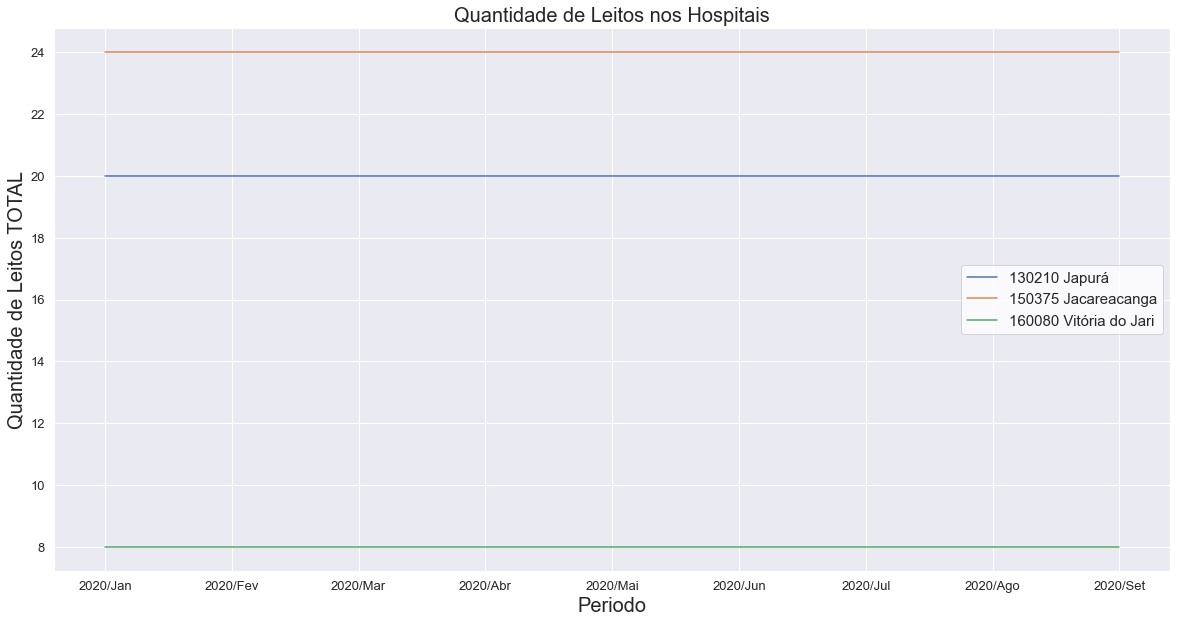

In [434]:
selec = leitos_total[leitos_total['cod_ibge'].isin(analise_perc_contaminados[analise_cont['ranking'] == 'top']['cod_ibge'])]
selec = selec.set_index('Município')
x =selec.T[:-1].plot(figsize = (20,10))
plt.title('Quantidade de Leitos nos Hospitais', fontsize=20)
plt.xlabel('Periodo', fontsize=20)
plt.ylabel('Quantidade de Leitos TOTAL', fontsize=20)
x.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
#plt.ylim(0, max(maximos)+15000000)
legend = plt.legend(loc='best',prop={'size': 15})
frame = legend.get_frame()
frame.set_facecolor('white')
x.tick_params(labelsize=13)

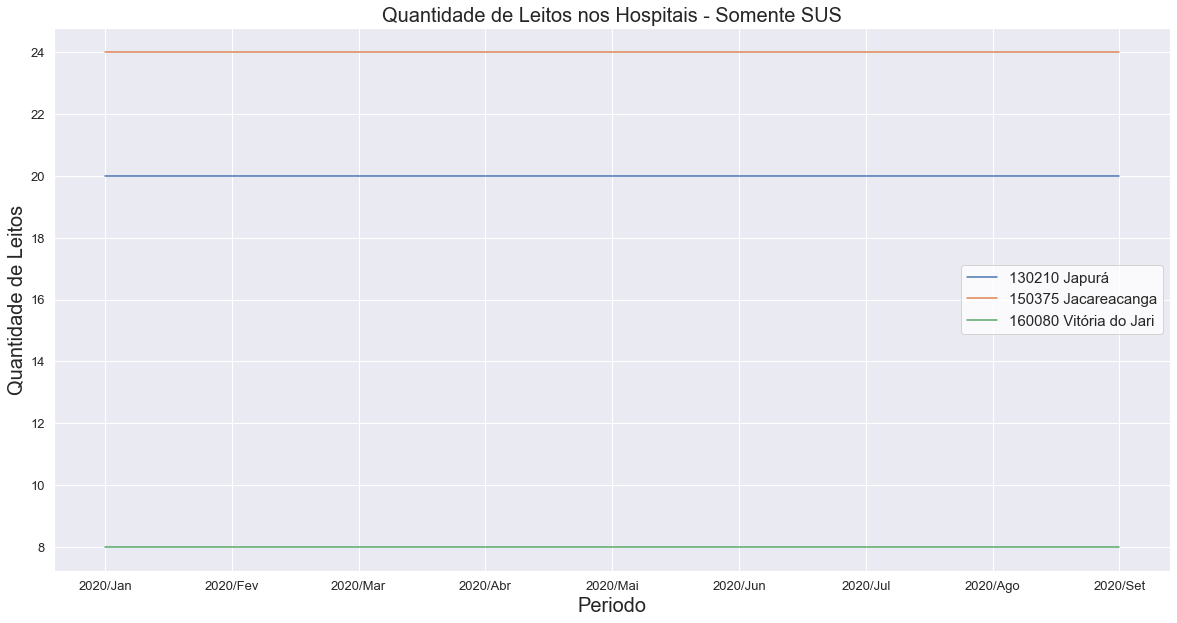

In [435]:
selec = leitos_sus[leitos_sus['cod_ibge'].isin(analise_perc_contaminados[analise_cont['ranking'] == 'top']['cod_ibge'])]
selec = selec.set_index('Município')
x =selec.T[:-1].plot(figsize = (20,10))
plt.title('Quantidade de Leitos nos Hospitais - Somente SUS', fontsize=20)
plt.xlabel('Periodo', fontsize=20)
plt.ylabel('Quantidade de Leitos', fontsize=20)
x.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
#plt.ylim(0, max(maximos)+15000000)
legend = plt.legend(loc='best',prop={'size': 15})
frame = legend.get_frame()
frame.set_facecolor('white')
x.tick_params(labelsize=13)

#### Inidicador de % de pessoas contaminadas - BOTTOM3

In [436]:
#Analisando apenas os municípios alvos no KPI de % de Contaminados
analise_perc_contaminados['last_available_date'] = pd.to_datetime(analise_perc_contaminados['last_available_date'], format = '%Y-%m-%d')
analise_cont = analise_perc_contaminados[['city','last_available_date','last_available_confirmed_per_100k_inhabitants','ranking']]

(0.0, 2994.5827)

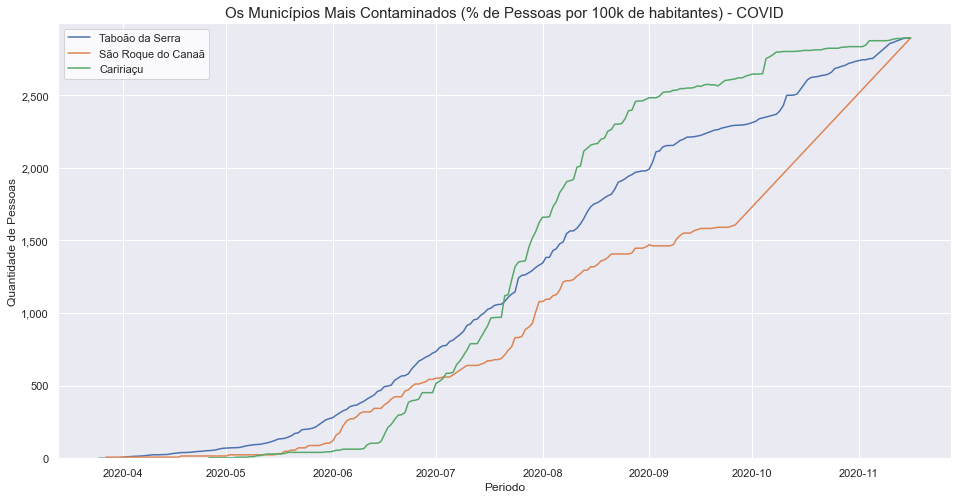

In [437]:
#Analisar os 3 ultimos
selec_1 = analise_cont[analise_cont['ranking'] == 'bottom']
sns.set_theme(style="darkgrid")
plt.figure(figsize=(16,8))
ax = sns.lineplot(x="last_available_date", y="last_available_confirmed_per_100k_inhabitants",
             hue="city",
             data=selec_1)
plt.title('Os Municípios Mais Contaminados (% de Pessoas por 100k de habitantes) - COVID', fontsize=15)
plt.xlabel('Periodo', fontsize=12)
plt.ylabel('Quantidade de Pessoas', fontsize=12)
legend = plt.legend(loc=2)
frame = legend.get_frame()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
frame.set_facecolor('white')
maxlim = selec_1["last_available_confirmed_per_100k_inhabitants"].max()
plt.ylim(0, maxlim+100)

(0.0, 312164.0)

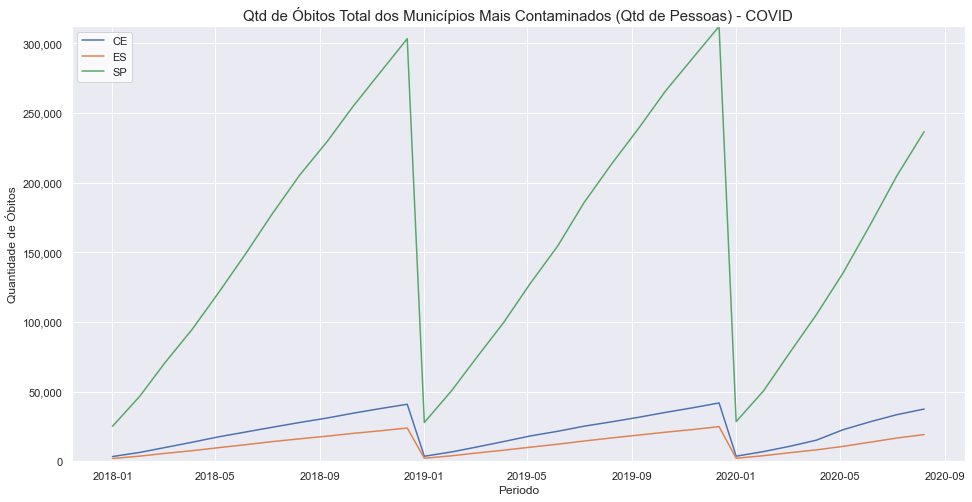

In [438]:
#Verificar o comportamento do gráfico sobre a qtd de óbitos nos estados dos municípios
selec_1 = obitos[obitos['state'].isin(analise_perc_contaminados[analise_cont['ranking'] == 'bottom']['state'].unique())]
selec_1 = selec_1.sort_values(['year','state','month'])
selec_1['mortes_acum']=selec_1.groupby(['year','state'])['deaths'].cumsum()
plt.figure(figsize=(16,8))
ax = sns.lineplot(x="date", y="mortes_acum",
             hue="state",
             data=selec_1)
plt.title('Qtd de Óbitos Total dos Municípios Mais Contaminados (Qtd de Pessoas) - COVID', fontsize=15)
plt.xlabel('Periodo', fontsize=12)
plt.ylabel('Quantidade de Óbitos', fontsize=12)
legend = plt.legend(loc=2)
frame = legend.get_frame()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
frame.set_facecolor('white')
maxlim = selec_1["mortes_acum"].max()
plt.ylim(0, maxlim)

Text(0, 0.5, 'Quantidade de Óbitos')

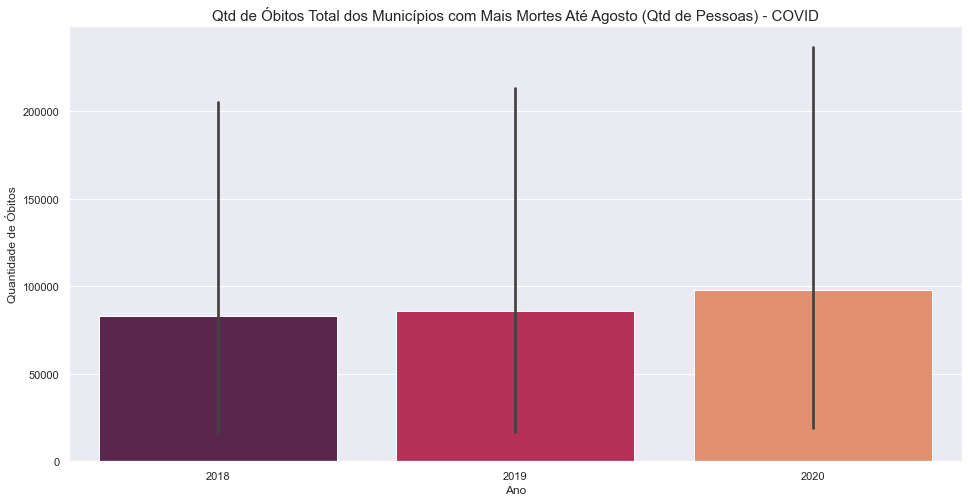

In [439]:
#Avaliar a QTD de óbitos acumuladas até Agosto
selec_1 = selec_1[selec_1['month'] == 8]
plt.figure(figsize=(16,8))
sns.barplot(x='year', y="mortes_acum", palette="rocket", data=selec_1)
plt.title('Qtd de Óbitos Total dos Municípios com Mais Mortes Até Agosto (Qtd de Pessoas) - COVID', fontsize=15)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Quantidade de Óbitos', fontsize=12)

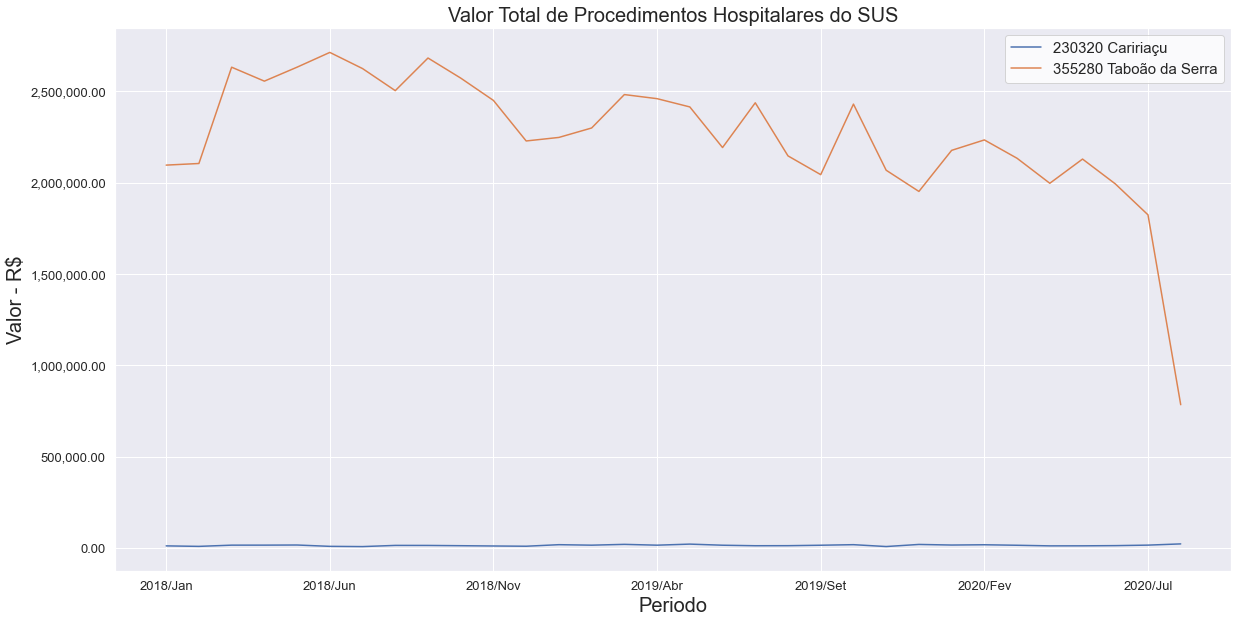

In [440]:
#Avaliar os gastos do SUS
selec = gasto_sus[gasto_sus['cod_ibge'].isin(analise_perc_contaminados[analise_cont['ranking'] == 'bottom']['cod_ibge'])]
selec = selec.set_index('Município')
x =selec.T[:-1].plot(figsize = (20,10))
plt.title('Valor Total de Procedimentos Hospitalares do SUS', fontsize=20)
plt.xlabel('Periodo', fontsize=20)
plt.ylabel('Valor - R$', fontsize=20)
x.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
#plt.ylim(0, max(maximos)+15000000)
legend = plt.legend(loc='best',prop={'size': 15})
frame = legend.get_frame()
frame.set_facecolor('white')
x.tick_params(labelsize=13)

Não foram encontrados dados de voos.

Text(0, 0.5, 'Km^2')

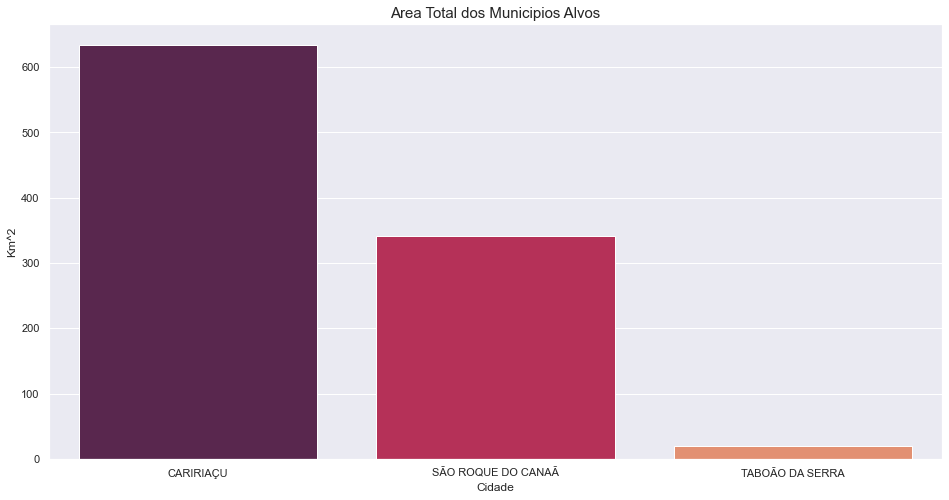

In [441]:
selec = area_mun[area_mun['cod_ibge'].isin(analise_perc_contaminados[analise_cont['ranking'] == 'bottom']['cod_ibge'])]
plt.figure(figsize=(16,8))
sns.barplot(x='NM_MUN_2019', y="AR_MUN_2019", palette="rocket", data=selec)
plt.title('Area Total dos Municipios Alvos', fontsize=15)
plt.xlabel('Cidade', fontsize=12)
plt.ylabel('Km^2', fontsize=12)

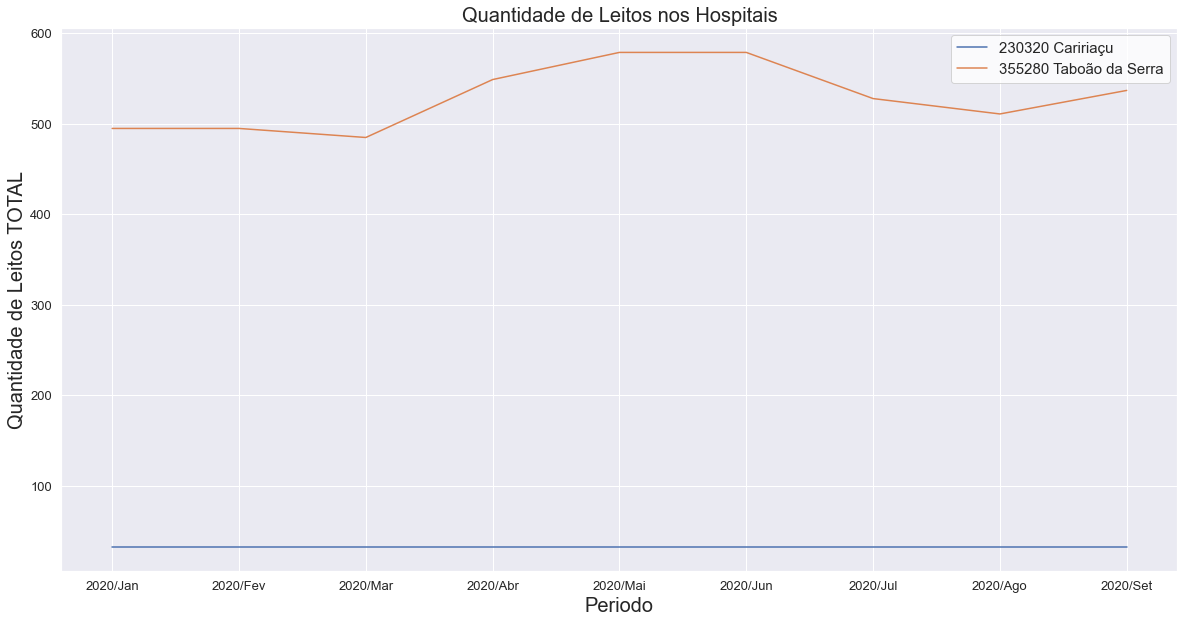

In [442]:
selec = leitos_total[leitos_total['cod_ibge'].isin(analise_perc_contaminados[analise_cont['ranking'] == 'bottom']['cod_ibge'])]
selec = selec.set_index('Município')
x =selec.T[:-1].plot(figsize = (20,10))
plt.title('Quantidade de Leitos nos Hospitais', fontsize=20)
plt.xlabel('Periodo', fontsize=20)
plt.ylabel('Quantidade de Leitos TOTAL', fontsize=20)
x.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
#plt.ylim(0, max(maximos)+15000000)
legend = plt.legend(loc='best',prop={'size': 15})
frame = legend.get_frame()
frame.set_facecolor('white')
x.tick_params(labelsize=13)

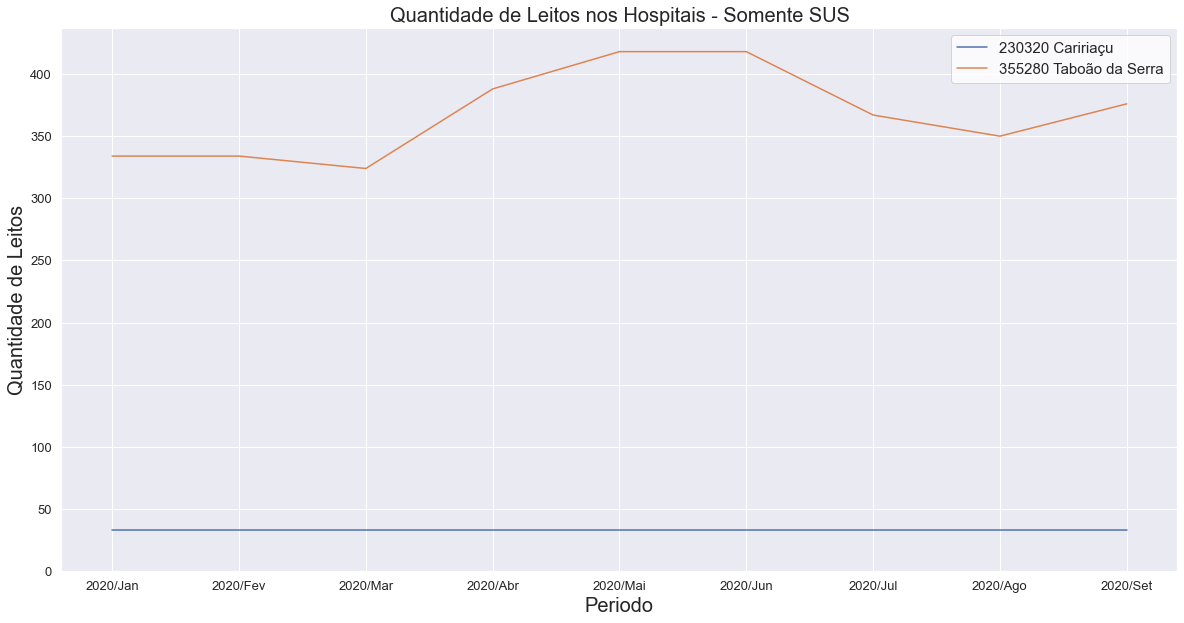

In [443]:
selec = leitos_sus[leitos_sus['cod_ibge'].isin(analise_perc_contaminados[analise_cont['ranking'] == 'bottom']['cod_ibge'])]
selec = selec.set_index('Município')
x =selec.T[:-1].plot(figsize = (20,10))
plt.title('Quantidade de Leitos nos Hospitais - Somente SUS', fontsize=20)
plt.xlabel('Periodo', fontsize=20)
plt.ylabel('Quantidade de Leitos', fontsize=20)
x.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylim(0)
legend = plt.legend(loc='best',prop={'size': 15})
frame = legend.get_frame()
frame.set_facecolor('white')
x.tick_params(labelsize=13)

#### Inidicador de QTD de óbitos pelo COVID - TOP3

In [444]:
#Analisando apenas os municípios alvos no KPI de QTD de Óbitos
analise_qtd_mortes['last_available_date'] = pd.to_datetime(analise_qtd_mortes['last_available_date'], format = '%Y-%m-%d')
analise_cont = analise_qtd_mortes[['city','last_available_date','last_available_deaths','ranking']]

(0.0, 18958.0)

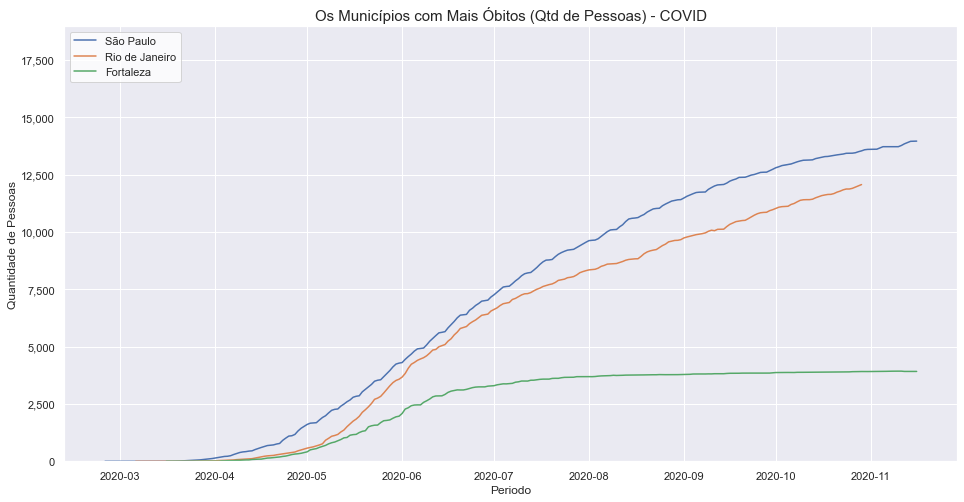

In [445]:
#Analisar os 3 primeiros
selec_1 = analise_cont[analise_cont['ranking'] == 'top']
sns.set_theme(style="darkgrid")
plt.figure(figsize=(16,8))
ax = sns.lineplot(x="last_available_date", y="last_available_deaths",
             hue="city",
             data=selec_1)
plt.title('Os Municípios com Mais Óbitos (Qtd de Pessoas) - COVID', fontsize=15)
plt.xlabel('Periodo', fontsize=12)
plt.ylabel('Quantidade de Pessoas', fontsize=12)
legend = plt.legend(loc=2)
frame = legend.get_frame()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
frame.set_facecolor('white')
maxlim = selec_1["last_available_deaths"].max()
plt.ylim(0, maxlim+5000)

(0.0, 362164.0)

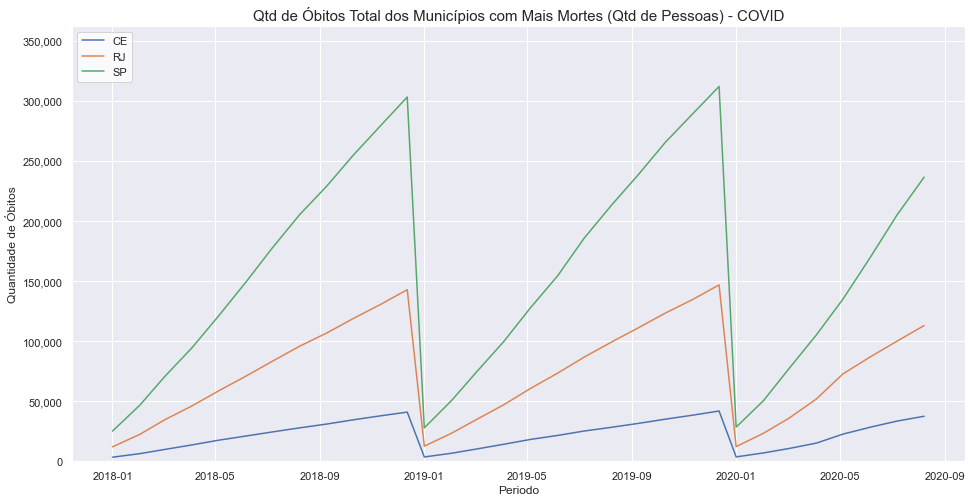

In [446]:
#Verificar o comportamento do gráfico sobre a qtd de óbitos nos estados dos municípios
selec_1 = obitos[obitos['state'].isin(analise_qtd_mortes[analise_cont['ranking'] == 'top']['state'].unique())]
selec_1 = selec_1.sort_values(['year','state','month'])
selec_1['mortes_acum']=selec_1.groupby(['year','state'])['deaths'].cumsum()
plt.figure(figsize=(16,8))
ax = sns.lineplot(x="date", y="mortes_acum",
             hue="state",
             data=selec_1)
plt.title('Qtd de Óbitos Total dos Municípios com Mais Mortes (Qtd de Pessoas) - COVID', fontsize=15)
plt.xlabel('Periodo', fontsize=12)
plt.ylabel('Quantidade de Óbitos', fontsize=12)
legend = plt.legend(loc=2)
frame = legend.get_frame()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
frame.set_facecolor('white')
maxlim = selec_1["mortes_acum"].max()
plt.ylim(0, maxlim+50000)

Text(0, 0.5, 'Quantidade de Óbitos')

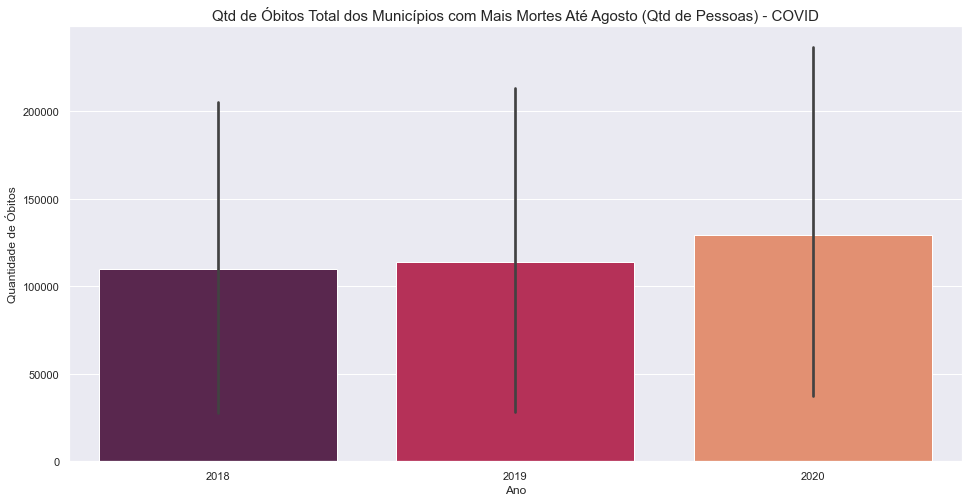

In [447]:
#Avaliar a QTD de óbitos acumuladas até Agosto
selec_1 = selec_1[selec_1['month'] == 8]
plt.figure(figsize=(16,8))
sns.barplot(x='year', y="mortes_acum", palette="rocket", data=selec_1)
plt.title('Qtd de Óbitos Total dos Municípios com Mais Mortes Até Agosto (Qtd de Pessoas) - COVID', fontsize=15)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Quantidade de Óbitos', fontsize=12)

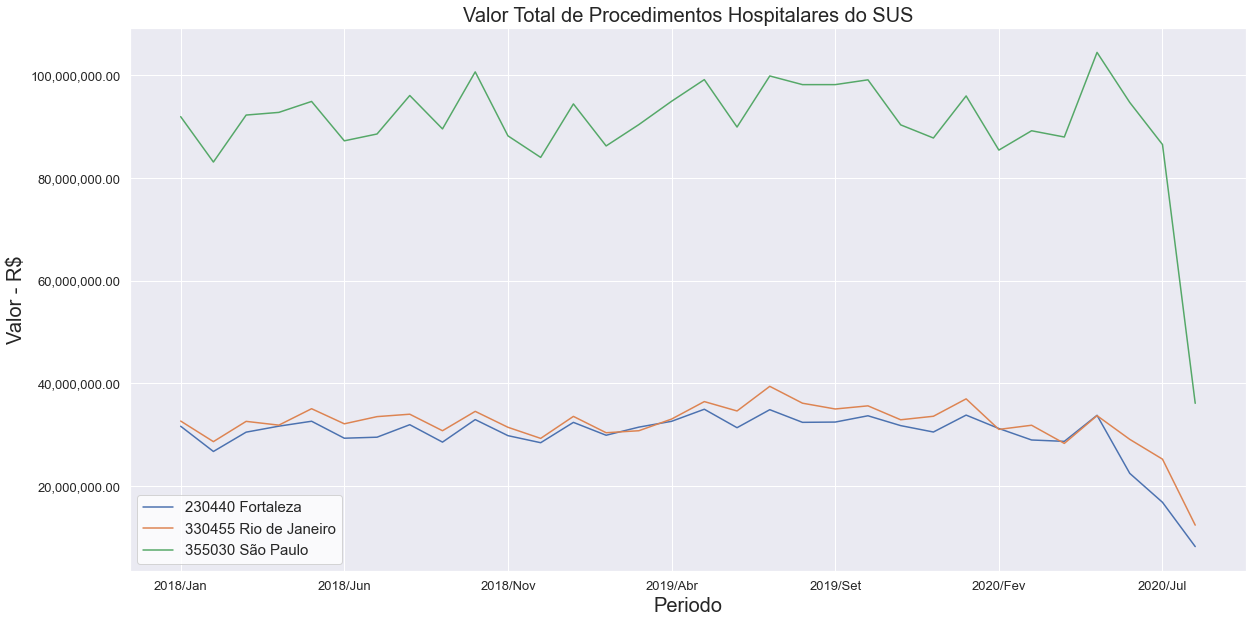

In [448]:
#Avaliar os gastos do SUS
selec = gasto_sus[gasto_sus['cod_ibge'].isin(analise_qtd_mortes[analise_cont['ranking'] == 'top']['cod_ibge'])]
selec = selec.set_index('Município')
x =selec.T[:-1].plot(figsize = (20,10))
plt.title('Valor Total de Procedimentos Hospitalares do SUS', fontsize=20)
plt.xlabel('Periodo', fontsize=20)
plt.ylabel('Valor - R$', fontsize=20)
x.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
#plt.ylim(0, max(maximos)+15000000)
legend = plt.legend(loc='best',prop={'size': 15})
frame = legend.get_frame()
frame.set_facecolor('white')
x.tick_params(labelsize=13)

In [449]:
lista_de_aeroportos = ['GUARULHOS', 'SÃO PAULO', 'RIO DE JANEIRO', 'FORTALEZA']
selec = pd.DataFrame(voos[voos['nm_municipio_destino'].isin(lista_de_aeroportos)].groupby(['data_formatada','nm_municipio_destino'])['passageiros_total'].sum())

(0.0, 2208079.0)

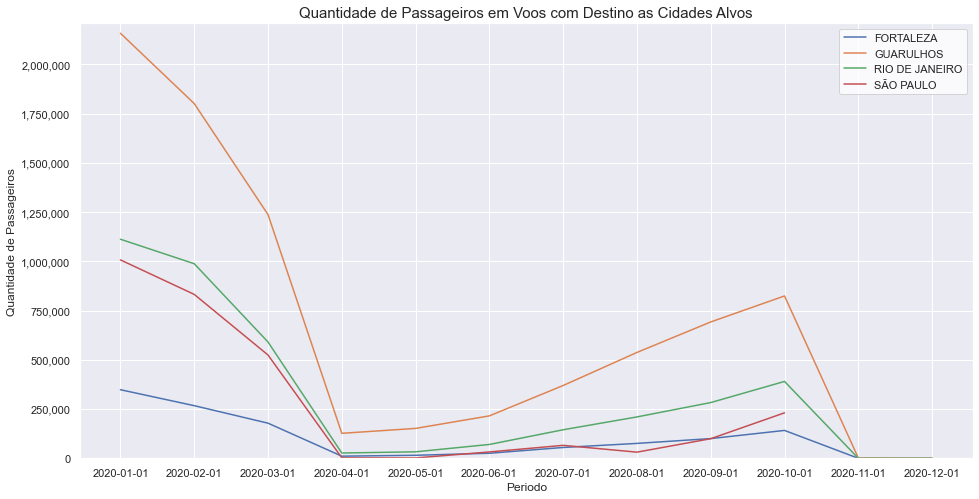

In [450]:
plt.figure(figsize=(16,8))
ax = sns.lineplot(x="data_formatada", y="passageiros_total",
             hue="nm_municipio_destino",
             data=selec)
plt.title('Quantidade de Passageiros em Voos com Destino as Cidades Alvos', fontsize=15)
plt.xlabel('Periodo', fontsize=12)
plt.ylabel('Quantidade de Passageiros', fontsize=12)
legend = plt.legend(loc='best')
frame = legend.get_frame()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
frame.set_facecolor('white')
maxlim = selec["passageiros_total"].max()
plt.ylim(0, maxlim+50000)

Text(0, 0.5, 'Km^2')

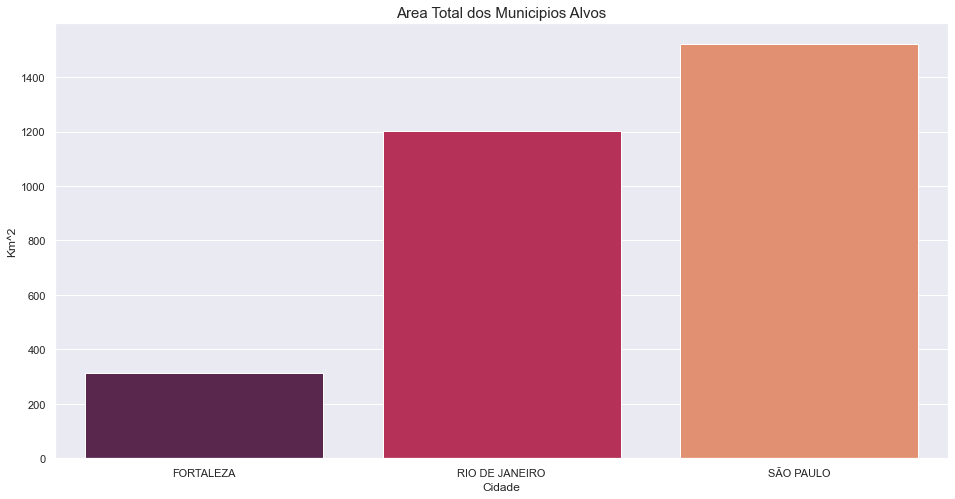

In [451]:
selec = area_mun[area_mun['cod_ibge'].isin(analise_qtd_mortes[analise_cont['ranking'] == 'top']['cod_ibge'])]
plt.figure(figsize=(16,8))
sns.barplot(x='NM_MUN_2019', y="AR_MUN_2019", palette="rocket", data=selec)
plt.title('Area Total dos Municipios Alvos', fontsize=15)
plt.xlabel('Cidade', fontsize=12)
plt.ylabel('Km^2', fontsize=12)

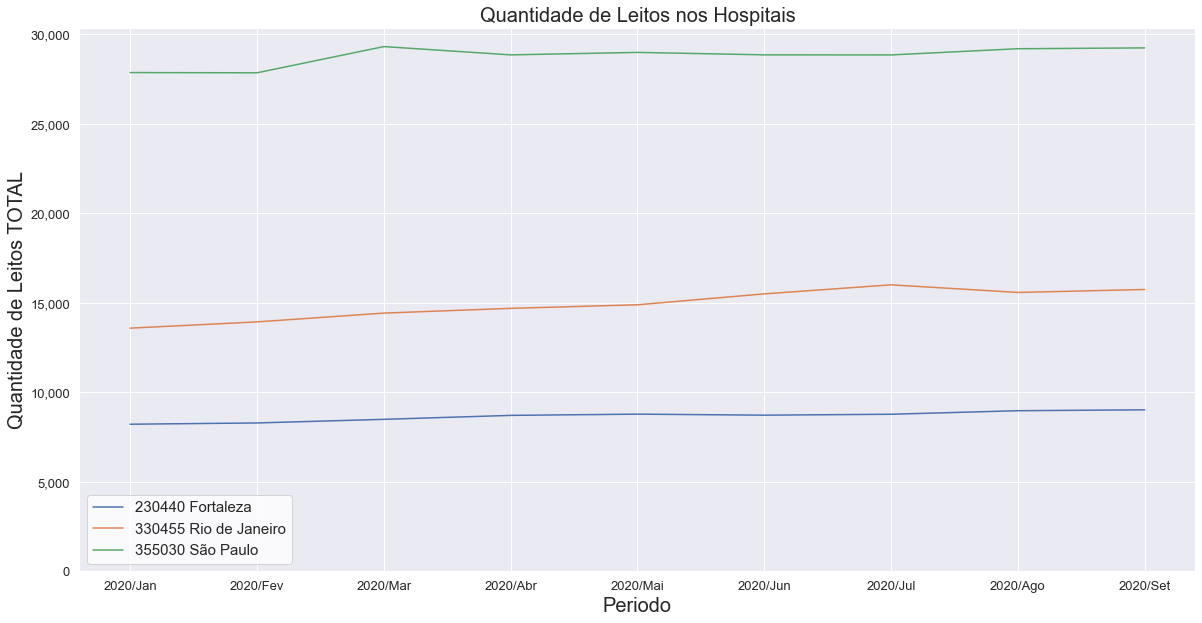

In [452]:
selec = leitos_total[leitos_total['cod_ibge'].isin(analise_qtd_mortes[analise_cont['ranking'] == 'top']['cod_ibge'])]
selec = selec.set_index('Município')
x =selec.T[:-1].plot(figsize = (20,10))
plt.title('Quantidade de Leitos nos Hospitais', fontsize=20)
plt.xlabel('Periodo', fontsize=20)
plt.ylabel('Quantidade de Leitos TOTAL', fontsize=20)
x.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylim(0)
legend = plt.legend(loc='best',prop={'size': 15})
frame = legend.get_frame()
frame.set_facecolor('white')
x.tick_params(labelsize=13)

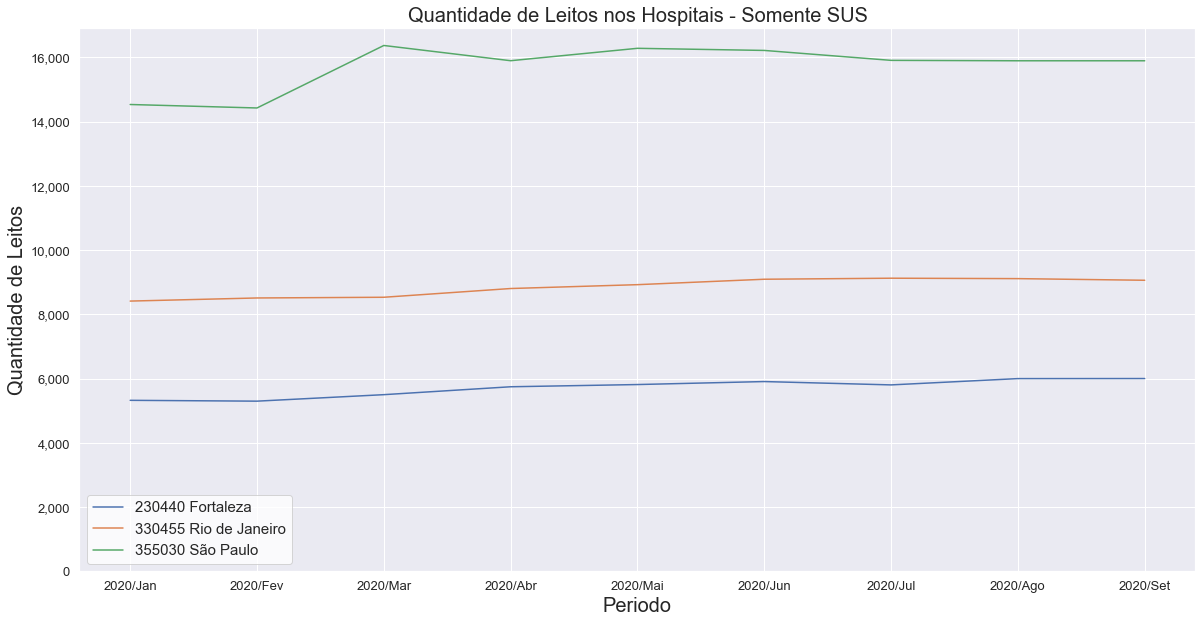

In [453]:
selec = leitos_sus[leitos_sus['cod_ibge'].isin(analise_qtd_mortes[analise_cont['ranking'] == 'top']['cod_ibge'])]
selec = selec.set_index('Município')
x =selec.T[:-1].plot(figsize = (20,10))
plt.title('Quantidade de Leitos nos Hospitais - Somente SUS', fontsize=20)
plt.xlabel('Periodo', fontsize=20)
plt.ylabel('Quantidade de Leitos', fontsize=20)
x.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylim(0)
legend = plt.legend(loc='best',prop={'size': 15})
frame = legend.get_frame()
frame.set_facecolor('white')
x.tick_params(labelsize=13)

#### Inidicador de QTD de óbitos pelo COVID - BOTTOM3

In [454]:
#Analisando apenas os municípios alvos no KPI de QTD de Contaminados
analise_qtd_mortes['last_available_date'] = pd.to_datetime(analise_qtd_mortes['last_available_date'], format = '%Y-%m-%d')
analise_cont = analise_qtd_mortes[['city','last_available_date','last_available_deaths','ranking']]

(0.0, 12.0)

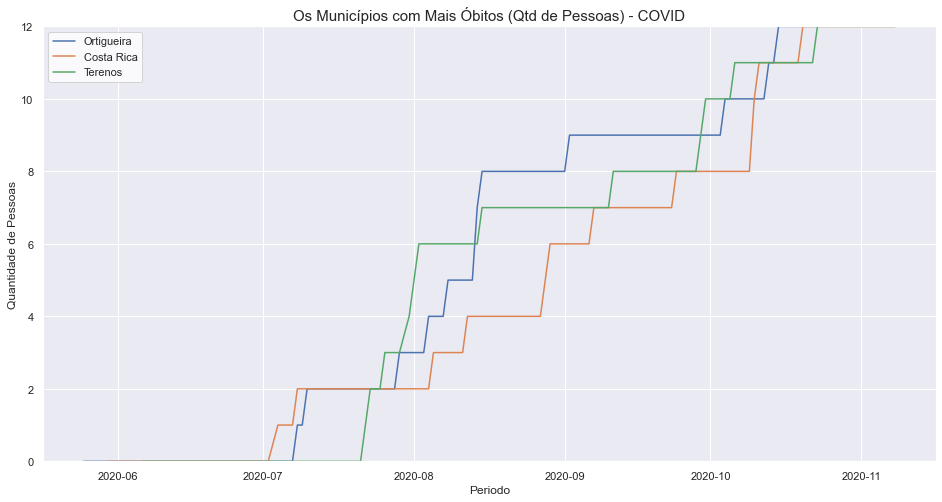

In [455]:
#Analisar os 3 ultimos
selec_1 = analise_cont[analise_cont['ranking'] == 'bottom']
sns.set_theme(style="darkgrid")
plt.figure(figsize=(16,8))
ax = sns.lineplot(x="last_available_date", y="last_available_deaths",
             hue="city",
             data=selec_1)
plt.title('Os Municípios com Mais Óbitos (Qtd de Pessoas) - COVID', fontsize=15)
plt.xlabel('Periodo', fontsize=12)
plt.ylabel('Quantidade de Pessoas', fontsize=12)
legend = plt.legend(loc=2)
frame = legend.get_frame()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
frame.set_facecolor('white')
maxlim = selec_1["last_available_deaths"].max()
plt.ylim(0, maxlim)

(0.0, 124285.0)

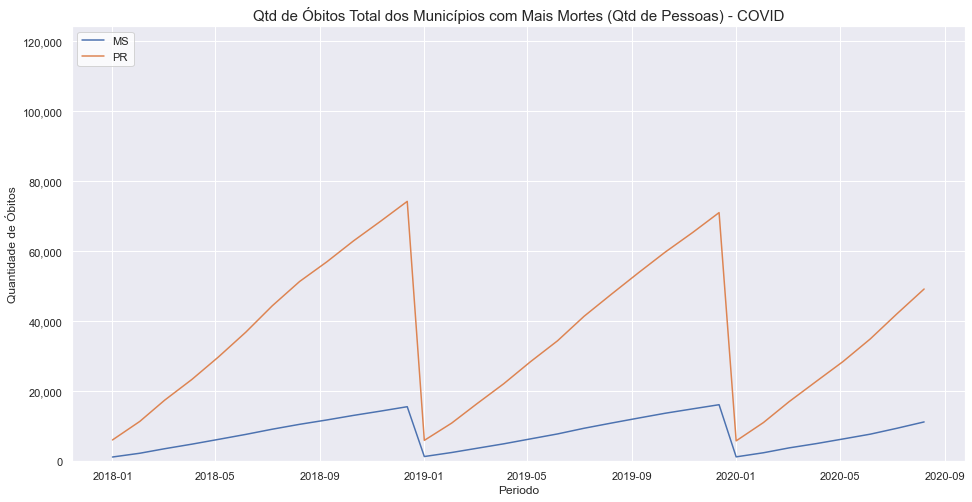

In [456]:
#Verificar o comportamento do gráfico sobre a QTD de óbitos nos estados dos municípios
selec_1 = obitos[obitos['state'].isin(analise_qtd_mortes[analise_cont['ranking'] == 'bottom']['state'].unique())]
selec_1 = selec_1.sort_values(['year','state','month'])
selec_1['mortes_acum']=selec_1.groupby(['year','state'])['deaths'].cumsum()
plt.figure(figsize=(16,8))
ax = sns.lineplot(x="date", y="mortes_acum",
             hue="state",
             data=selec_1)
plt.title('Qtd de Óbitos Total dos Municípios com Mais Mortes (Qtd de Pessoas) - COVID', fontsize=15)
plt.xlabel('Periodo', fontsize=12)
plt.ylabel('Quantidade de Óbitos', fontsize=12)
legend = plt.legend(loc=2)
frame = legend.get_frame()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
frame.set_facecolor('white')
maxlim = selec_1["mortes_acum"].max()
plt.ylim(0, maxlim+50000)

Text(0, 0.5, 'Quantidade de Óbitos')

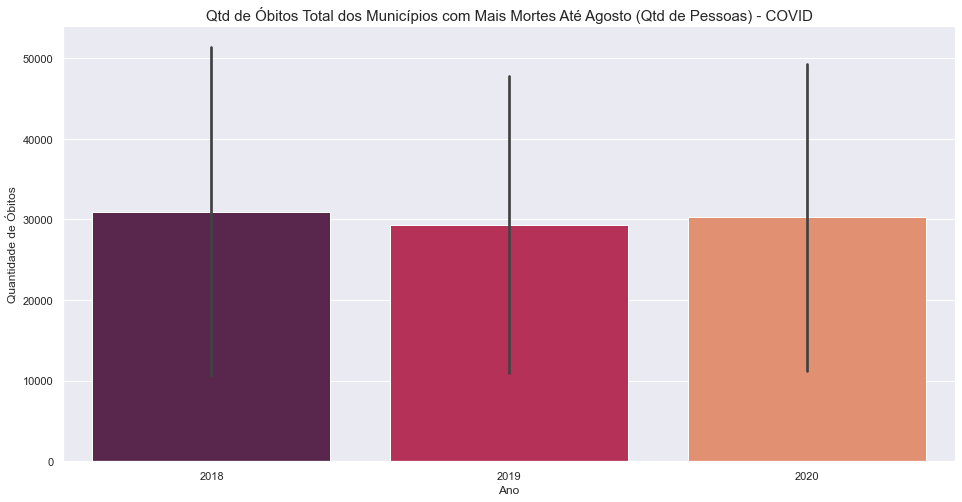

In [457]:
#Avaliar a QTD de óbitos acumuladas até Agosto
selec_1 = selec_1[selec_1['month'] == 8]
plt.figure(figsize=(16,8))
sns.barplot(x='year', y="mortes_acum", palette="rocket", data=selec_1)
plt.title('Qtd de Óbitos Total dos Municípios com Mais Mortes Até Agosto (Qtd de Pessoas) - COVID', fontsize=15)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Quantidade de Óbitos', fontsize=12)

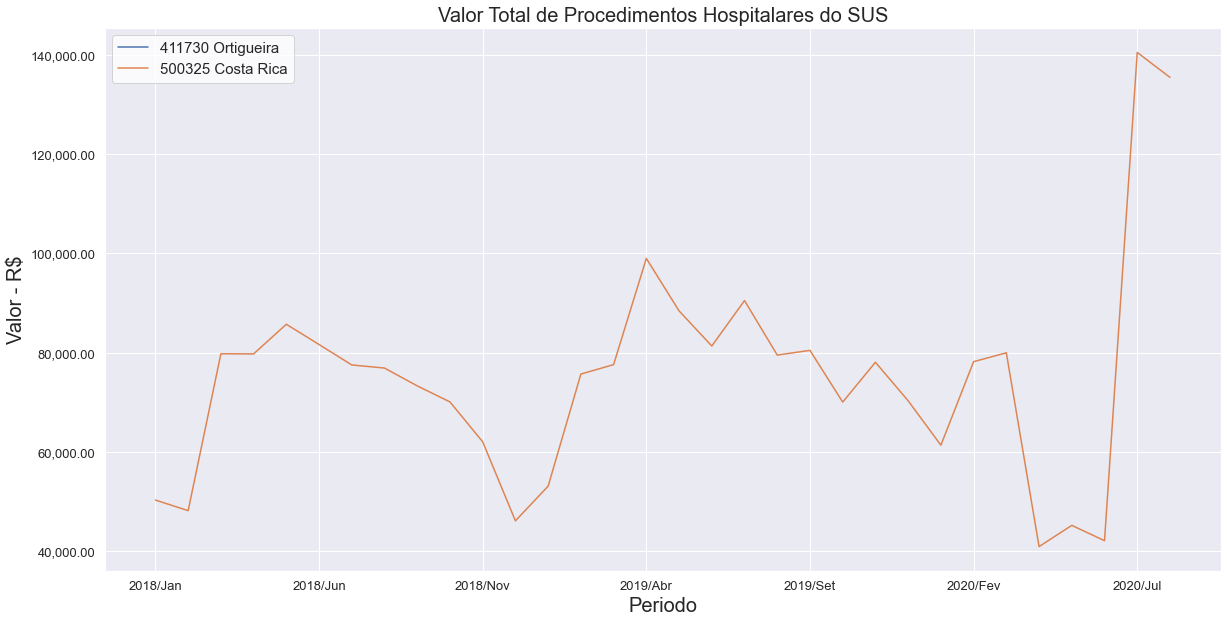

In [458]:
#Avaliar os gastos do SUS
selec = gasto_sus[gasto_sus['cod_ibge'].isin(analise_qtd_mortes[analise_cont['ranking'] == 'bottom']['cod_ibge'])]
selec = selec.set_index('Município')
x =selec.T[:-1].plot(figsize = (20,10))
plt.title('Valor Total de Procedimentos Hospitalares do SUS', fontsize=20)
plt.xlabel('Periodo', fontsize=20)
plt.ylabel('Valor - R$', fontsize=20)
x.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
#plt.ylim(0, max(maximos)+15000000)
legend = plt.legend(loc='best',prop={'size': 15})
frame = legend.get_frame()
frame.set_facecolor('white')
x.tick_params(labelsize=13)

Não há informação de voos com destino à esses municípios

Text(0, 0.5, 'Km^2')

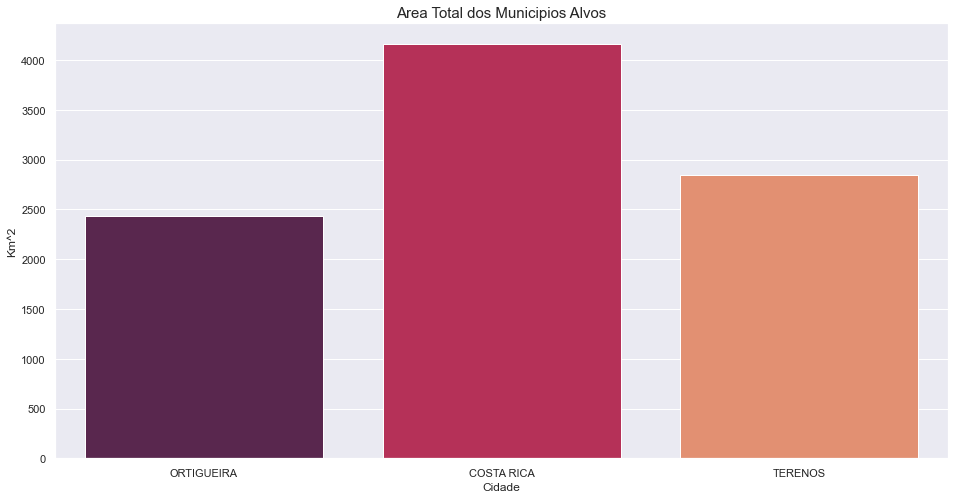

In [459]:
selec = area_mun[area_mun['cod_ibge'].isin(analise_qtd_mortes[analise_cont['ranking'] == 'bottom']['cod_ibge'])]
plt.figure(figsize=(16,8))
sns.barplot(x='NM_MUN_2019', y="AR_MUN_2019", palette="rocket", data=selec)
plt.title('Area Total dos Municipios Alvos', fontsize=15)
plt.xlabel('Cidade', fontsize=12)
plt.ylabel('Km^2', fontsize=12)

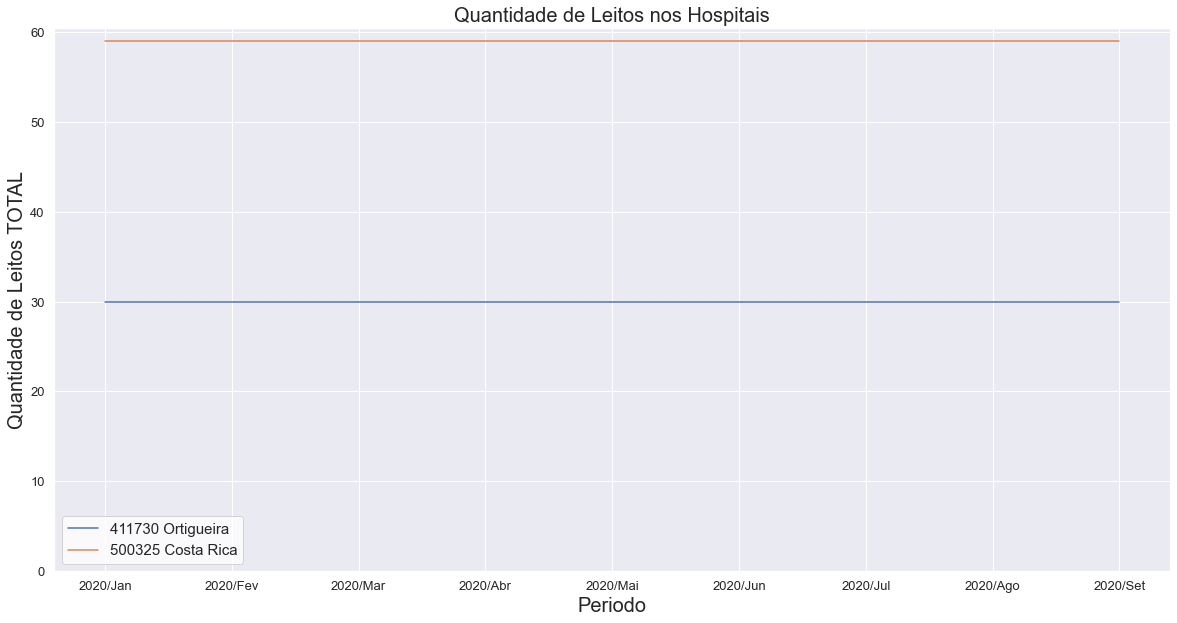

In [460]:
selec = leitos_total[leitos_total['cod_ibge'].isin(analise_qtd_mortes[analise_cont['ranking'] == 'bottom']['cod_ibge'])]
selec = selec.set_index('Município')
x =selec.T[:-1].plot(figsize = (20,10))
plt.title('Quantidade de Leitos nos Hospitais', fontsize=20)
plt.xlabel('Periodo', fontsize=20)
plt.ylabel('Quantidade de Leitos TOTAL', fontsize=20)
x.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylim(0)
legend = plt.legend(loc='best',prop={'size': 15})
frame = legend.get_frame()
frame.set_facecolor('white')
x.tick_params(labelsize=13)

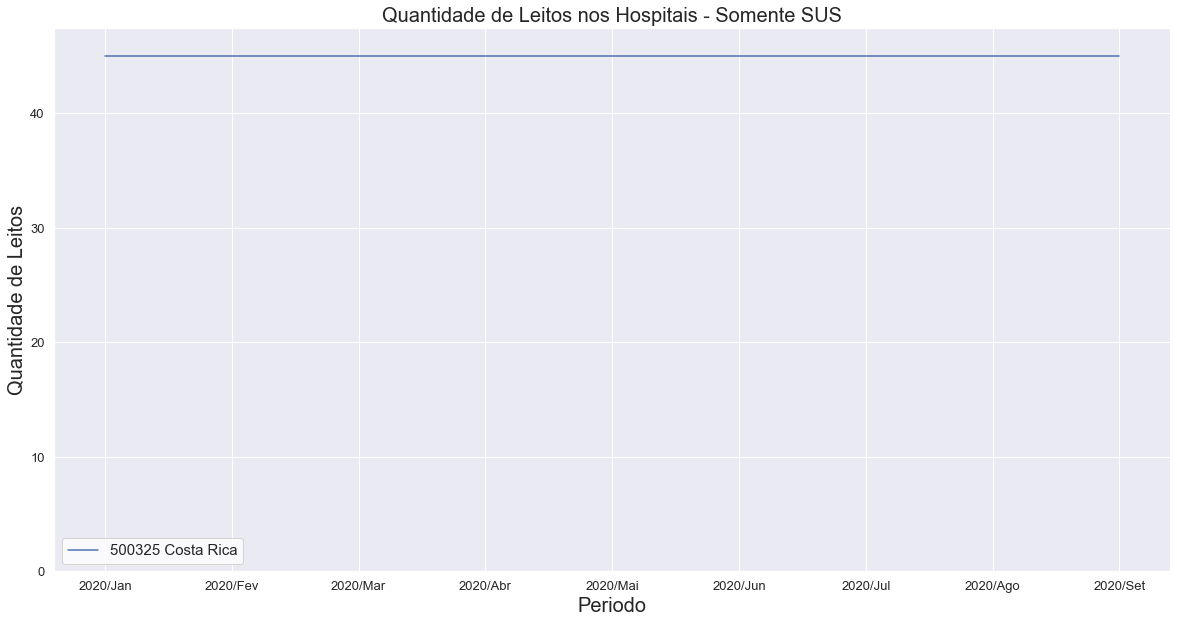

In [461]:
selec = leitos_sus[leitos_sus['cod_ibge'].isin(analise_qtd_mortes[analise_cont['ranking'] == 'bottom']['cod_ibge'])]
selec = selec.set_index('Município')
x =selec.T[:-1].plot(figsize = (20,10))
plt.title('Quantidade de Leitos nos Hospitais - Somente SUS', fontsize=20)
plt.xlabel('Periodo', fontsize=20)
plt.ylabel('Quantidade de Leitos', fontsize=20)
x.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylim(0)
legend = plt.legend(loc='best',prop={'size': 15})
frame = legend.get_frame()
frame.set_facecolor('white')
x.tick_params(labelsize=13)

### 4º Passo: Conclusão

Agora que temos os gráficos plotados e as informações principais de cada municipio alvo que filtramos, podemos observar qual é o comportamento dos dados:

•	Na análise de QTD de contaminados - Relação dos 3 primeiros (TOP) é muito preocupante, visto que todos os indicadores estão aumentando conforme dados históricos. Outro fator importante é a proporção do tamanho da cidade pelo número de habitantes, Observe que São Paulo e Rio de Janeiro tem a área da cidade muito menor do que Brasilía e nas outras duas cidades o número de contaminados é muito maior. Em São Paulo há um alto número de pessoas transitando na chegada dos aeroportos de São Paulo. Os três munícpios possuem a proporção apeoximada de 60% ds leitos sao da rede particular. Já na relação dos últimos (BOTTOM) munípios alvos, é perceptivel que a tendência da curva de contaminados está reduzindo, mas o fato dos três municípios serem de pequenos, me intriga esse posicionamento, será que os dados estão sendo transmitidos com qualidade? Perceba que até mesmo a informação de qauntidade de leitos possui uma falha, poderia ser outro fator para analisarmos.

•	Na análise de % de contaminados - Vamos começar analisando o gráfico do % de contaminados do TOP3, a curva do gráfico ainda não demonstrou uma estabilidade nos número, ou seja, os números não são bons. A Quantidade de óbitos só está aumentando conforme o tempo está passando, os gastos do sus estão diminuindo, vários fatores ruins para essas cidades. Já para o BOTTOM analisamos três municípios que estão com um aumento no % de contaminação, mas precisamos analisar com uma cautela a cidade Taboão da Serra, onde o mesmo possui um aumento expressimo do numero de casos e que possui um alto número de pessoas na cidade.

•	Na análise de QTD de obitos - Novamente Rio de Janeiro e São Paulo estão no topo das nossas análise. Nessa análise Fortaleza também é adicionado nas cidades que estamos analisando, e essa cidade também possui agravantes de área total e de chegadas de viagens relevantes. Para a análise BOTTOM deste indicador, nós não conseguimos resultados tão conclusivos pois foi adicionadas cidades pequenas, o que dificulta qualquer análise com uma amostra tão pequena no lugar.

Após toda a análise dos dados, eu consegui colocar em fatos o quanto é preocupante se São Paulo ou Rio de Janeiro entrarem em colapso com relação a contaminação do vírus, há muitas pessoas concentradas em tão pequenas áreas, somente 40% da quantidade dos leitos totais (aproximadamente) são públicos, a conexão com várias cidades e ser um destino de várias viagens faz com que os agravantes só aumentem.
